# Classifiers Gravitational Wave Demo

In [ ]:
USE_NEW_GENERATOR = True  # set False to use the legacy toy generator below

SIGNAL_AMPLITUDE = 5  # tweak amplitude to study sensitivity
num_backgrounds = 100
num_signals = 10

# If True, train the conditional flow using only background windows (exclude injected signals).
# Set to False to train the flow on the full mixed dataset (background + signals).
FLOW_TRAIN_USE_ONLY_BACKGROUND = True

# If True, train a separate flow per window by leaving it out, then sample for that window.
# WARNING: This is O(N) flow trainings and can be extremely slow for large N.
FLOW_TRAIN_LEAVE_ONE_OUT = True
NUM_FLOW_EPOCHS = 10

USE_EXTERNAL_CLASSIFIER = False  # set True to use notebooks/model.py
use_time_for_classifier = True # Only applies if not using external classifier
NUM_CLASSIFIER_EPOCHS = 50

## Setup

In [2]:
import os
import sys
import copy
import json
import pathlib
import numpy as np
import pandas as pd
import scipy
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform

# ensure project root (with 'config/' and 'src/') is on sys.path
project_root = pathlib.Path.cwd().resolve()
if not (project_root / "config").exists():
    candidate = project_root.parent
    if (candidate / "config").exists():
        project_root = candidate
if (project_root / "config").exists() and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Using project root: {project_root}")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "mps":
    torch.set_default_dtype(torch.float32)

torch.manual_seed(48)

Using project root: /Users/krishwu/code/ranode
Using device: mps


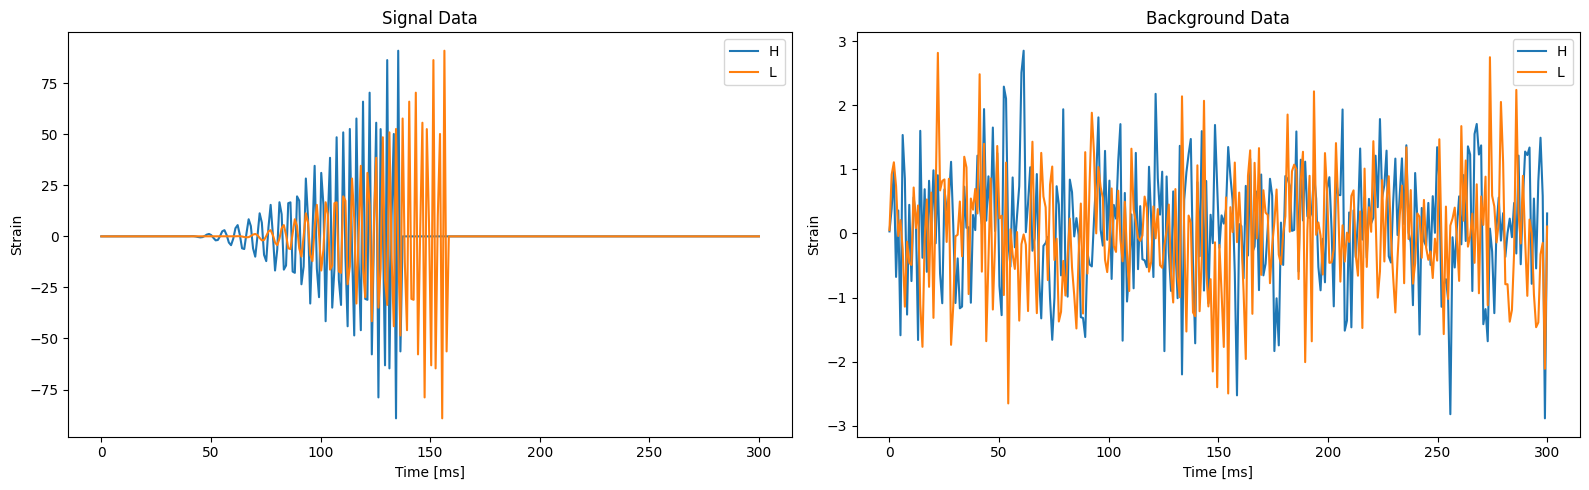

In [3]:
if USE_NEW_GENERATOR:
    notebooks_dir = project_root / "notebooks"
    if str(notebooks_dir) not in sys.path:
        sys.path.insert(0, str(notebooks_dir))
    import data_generation as gw_data

    def gen_sig(amplitude=100.0):
        sig_h = gw_data.generate_gw_signal(1, n_timesteps=300, amplitude=amplitude)[0]
        sig_l = gw_data.generate_gw_signal(1, n_timesteps=300, amplitude=amplitude)[0]
        t = np.linspace(0, 300, num=300)
        return np.stack([t, sig_h, sig_l], axis=1)

    def gen_bg():
        noise_h = gw_data.generate_noise(1, n_timesteps=300)[0]
        noise_l = gw_data.generate_noise(1, n_timesteps=300)[0]
        t = np.linspace(0, 300, num=300)
        return np.stack([t, noise_h, noise_l], axis=1)

else:
    def gen_sig(amplitude=100.0):
        """Generate toy signal data mimicking gravitational wave detection.
        
        Parameters
        ----------
        amplitude : float, default=100.0
            Signal amplitude scaling factor
        
        Returns
        -------
        numpy.ndarray
            Generated signal data with gravitational wave-like characteristics
        """
        T = 20.0 # ms
        delta = 5. # ms
        A = amplitude
        return gen_data(A,T,delta,0)

    def gen_bg():
        """Generate toy background data for gravitational wave analysis.
        
        Returns
        -------
        numpy.ndarray
            Generated background data without signal components
        """
        T = 20.0 # ms
        delta = 5. # ms
        A = 0.0
        return gen_data(A,T,delta,0.25)

    def gen_data(A, T, delta, noise):
        """Generate simulated gravitational wave detector data.
        
        Creates toy data mimicking gravitational wave signals in dual detectors
        with configurable amplitude, period, time delay, and noise levels.
        
        Parameters
        ----------
        A : float
            Signal amplitude
        T : float
            Signal period in milliseconds
        delta : float
            Time delay between detectors in milliseconds
        noise : float
            Gaussian noise standard deviation
            
        Returns
        -------
        numpy.ndarray, shape (100, 5)
            Generated data with columns [time, H_detector, L_detector, H+L, H-L]
            
        Notes
        -----
        This is a toy model for testing R-Anode methodology on simple
        time-series data before applying to particle physics datasets.
        """
        data = []
        for t in np.linspace(0,300,num=300): #ms
            h = A * np.sin(2*np.pi*t / T) * scipy.stats.norm.pdf(t,loc=150,scale=20) + np.random.normal(scale=noise)
            l = A * np.sin(2*np.pi*(t+delta) / T)* scipy.stats.norm.pdf(t+delta,loc=150,scale=20) + np.random.normal(scale=noise)
            data.append( [ t,h,l])

        return np.array(data)

sdata = gen_sig()
bdata = gen_bg()

# Plot signal and background data side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Signal data
ax1.plot(sdata[:,0],sdata[:,1],label="H")
ax1.plot(sdata[:,0],sdata[:,2],label="L")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Strain")
ax1.set_title("Signal Data")
ax1.legend()

# Background data
ax2.plot(bdata[:,0],bdata[:,1],label="H")
ax2.plot(bdata[:,0],bdata[:,2],label="L")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Strain")
ax2.set_title("Background Data")
ax2.legend()

plt.tight_layout()
plt.show()


Verified: signal is added sample-wise to the background
Background shape: (300, 3)
Signal template shape: (300, 3)
Signal+background combined shape: (300, 3)
Columns: [time, H, L, H+L, H-L, label]


[]

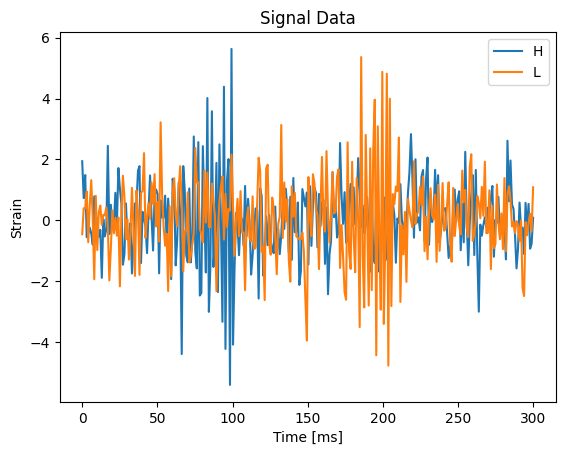

In [4]:
raw_bkg = gen_bg()
raw_sig = gen_sig(amplitude=SIGNAL_AMPLITUDE)

def combine_signal_with_background(background: np.ndarray, signal: np.ndarray, scale: float = 1.0) -> np.ndarray:
    if background.shape != signal.shape:
        raise ValueError("Signal and background must share identical shape")
    combined = background.copy()
    if not np.allclose(background[:, 0], signal[:, 0], atol=1e-8):
        raise ValueError("Time grids for signal and background do not align")
    combined[:, 1] = background[:, 1] + scale * signal[:, 1]
    combined[:, 2] = background[:, 2] + scale * signal[:, 2]
    return combined

combined_signal_raw = combine_signal_with_background(raw_bkg, raw_sig)
assert np.allclose(combined_signal_raw[:, 0], raw_bkg[:, 0])
assert np.allclose(combined_signal_raw[:, 1] - raw_bkg[:, 1], raw_sig[:, 1])
assert np.allclose(combined_signal_raw[:, 2] - raw_bkg[:, 2], raw_sig[:, 2])
print("Verified: signal is added sample-wise to the background")

print(f"Background shape: {raw_bkg.shape}")
print(f"Signal template shape: {raw_sig.shape}")
print(f"Signal+background combined shape: {combined_signal_raw.shape}")
print("Columns: [time, H, L, H+L, H-L, label]")

plt.clf()
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,1],label="H")
plt.plot(combined_signal_raw[:,0],combined_signal_raw[:,2],label="L")
plt.ylabel("Strain")
plt.title("Signal Data")
plt.xlabel("Time [ms]")
plt.legend()
plt.plot()


In [5]:
# You must already have these defined somewhere:
# def gen_bg(): ...
# def gen_sig(amplitude: float): ...

# -------- Dataset windows (background + injected signals) --------
time = np.linspace(0, 300, num=300)[:, None]  # (300,1)

bg_windows = [gen_bg() for _ in range(num_backgrounds)]       # each: (300,3) [time, H, L]
bg_windows = np.stack(bg_windows, axis=0)                     # (N_bg,300,3)

sig_windows = [
    combine_signal_with_background(gen_bg(), gen_sig(amplitude=SIGNAL_AMPLITUDE))
    for _ in range(num_signals)
]

all_windows = np.concatenate([bg_windows, np.stack(sig_windows, axis=0)], axis=0)
labels = np.array([0] * num_backgrounds + [1] * num_signals, dtype=int)

perm = np.random.default_rng(48).permutation(len(labels))
all_windows = all_windows[perm]
labels = labels[perm]

train_h = all_windows[:, :, 1].astype(np.float32)             # (N,300)
train_l = all_windows[:, :, 2].astype(np.float32)             # (N,300)

print("Dataset:", train_h.shape, train_l.shape)
print("Num backgrounds:", num_backgrounds, "Num signals:", num_signals)


Dataset: (110, 300) (110, 300)
Num backgrounds: 100 Num signals: 10


## Generate Flow

In [6]:
# Standardization from the flow training set (background-only if flag enabled)
if FLOW_TRAIN_USE_ONLY_BACKGROUND:
    flow_train_mask = labels == 0
else:
    flow_train_mask = np.ones_like(labels, dtype=bool)

mean_h = train_h[flow_train_mask].mean()
std_h  = train_h[flow_train_mask].std() + 1e-8
mean_l = train_l[flow_train_mask].mean()
std_l  = train_l[flow_train_mask].std() + 1e-8

def standardize(h, l):
    h_n = (h - mean_h) / std_h
    l_n = (l - mean_l) / std_l
    return h_n.astype(np.float32), l_n.astype(np.float32)

train_hn, train_ln = standardize(train_h, train_l)

# Build time conditioning in [0,1]
train_t = np.arange(train_hn.shape[0], dtype=np.float32)
train_t = (train_t - train_t.min()) / (train_t.max() - train_t.min() + 1e-8)

# Subset used for flow training
flow_train_hn = train_hn[flow_train_mask]
flow_train_ln = train_ln[flow_train_mask]
flow_train_t = train_t[flow_train_mask]


In [7]:
class FlowDataset(Dataset):
    def __init__(self, h_windows, l_windows, t_cond):
        assert h_windows.shape == l_windows.shape
        self.h = torch.as_tensor(h_windows, dtype=torch.float32)  # (N,300)
        self.l = torch.as_tensor(l_windows, dtype=torch.float32)  # (N,300)
        self.t = torch.as_tensor(t_cond, dtype=torch.float32)     # (N,)

    def __len__(self):
        return self.h.shape[0]

    def __getitem__(self, idx):
        x = torch.cat([self.h[idx], self.l[idx]], dim=0)          # (600,)
        c = self.t[idx].view(1)                                   # (1,)
        return x, c

flow_train_ds = FlowDataset(flow_train_hn, flow_train_ln, flow_train_t)
flow_train_loader = DataLoader(flow_train_ds, batch_size=256, shuffle=True)

In [8]:
def build_conditional_rqs_flow(
    dim=600,
    context_dim=1,
    num_layers=6,
    hidden_features=256,
    num_bins=8,
    tail_bound=3.0
):
    transforms = []
    for _ in range(num_layers):
        transforms.append(
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=dim,
                hidden_features=hidden_features,
                context_features=context_dim,
                num_bins=num_bins,
                tails="linear",
                tail_bound=tail_bound,
                activation=nn.ReLU(),
                dropout_probability=0.0,
                use_residual_blocks=True
            )
        )
        # Permute between layers so different dimensions get modeled in different order
        transforms.append(ReversePermutation(features=dim))

    transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=[dim])
    return Flow(transform, base_dist)

flow = build_conditional_rqs_flow(
    dim=600,
    context_dim=1,
    num_layers=6,
    hidden_features=256,
    num_bins=8,
    tail_bound=3.0
).to(torch.float32).to(device)

flow

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=600, out_features=256, bias=True)
          (context_layer): Linear(in_features=1, out_features=256, bias=True)
          (activation): ReLU()
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (context_layer): Linear(in_features=1, out_features=256, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=256, out_features=256, bias=True)
              )
              (activation): ReLU()
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=256, out_features=13800, bias=True)
        )
      )
      (1): ReversePermutation()
      (2): MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
     

Epoch 1/10 | NLL: 1401.275513
Epoch 2/10 | NLL: 1309.963989
Epoch 3/10 | NLL: 1244.170410
Epoch 4/10 | NLL: 1190.374390
Epoch 5/10 | NLL: 1147.065186
Epoch 6/10 | NLL: 1109.558228
Epoch 7/10 | NLL: 1076.211914
Epoch 8/10 | NLL: 1046.334106
Epoch 9/10 | NLL: 1018.292358
Epoch 10/10 | NLL: 992.223267


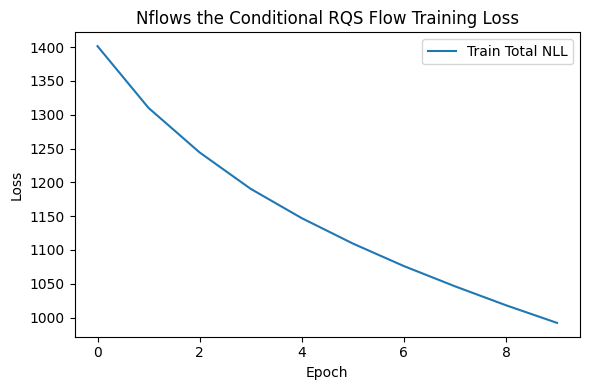

In [9]:
def train_nflows(flow, loader, epochs=50, lr=1e-4):
    flow.train()
    opt = optim.Adam(flow.parameters(), lr=lr)
    train_losses = []

    for ep in range(epochs):
        total_nll = 0.0
        count = 0

        for x, c in loader:
            x = x.to(device)  # (B,600)
            c = c.to(device)  # (B,1)

            opt.zero_grad()
            logp = flow.log_prob(inputs=x, context=c)  # (B,)
            nll = -logp.mean()
            nll.backward()
            opt.step()

            total_nll += nll.item() * x.size(0)
            count += x.size(0)
        train_losses.append(total_nll / count)

        print(f"Epoch {ep+1}/{epochs} | NLL: {total_nll/count:.6f}")

    return flow, train_losses

flow, train_losses = train_nflows(flow, flow_train_loader, epochs=NUM_FLOW_EPOCHS, lr=1e-4)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Total NLL")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Nflows the Conditional RQS Flow Training Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# def generate_flow_estimates(flow, t_cond, batch_size=512):
#     flow.eval()
#     N = len(t_cond)
#     X_hat = torch.zeros((N, 600), dtype=torch.float32)
#
#     with torch.no_grad():
#         for i in range(0, N, batch_size):
#             cb = torch.as_tensor(t_cond[i:i+batch_size], dtype=torch.float32).view(-1, 1).to(device)
#             # nflows Flow.sample(num_samples, context=...)
#             xb = flow.sample(num_samples=cb.size(0), context=cb).cpu()  # (B,600)
#             X_hat[i:i+batch_size] = xb
#
#     return X_hat.view(N, 2, 300)  # (N,2,300)

def generate_flow_estimates(flow, t_cond, batch_size=256):
    """
    Generates exactly ONE sample per context row.
    Returns X_hat: (N,2,300) torch.float32 on CPU.
    """
    flow.eval()
    N = len(t_cond)
    X_hat = torch.zeros((N, 600), dtype=torch.float32)

    with torch.no_grad():
        for i in tqdm(range(0, N, batch_size)):
            cb = torch.as_tensor(t_cond[i:i+batch_size], dtype=torch.float32).view(-1, 1).to(device)
            
            # IMPORTANT: one sample per context row
            xb = flow.sample(num_samples=1, context=cb)   # shape typically (B, 1, 600)
            xb = xb.squeeze(1).cpu()                      # -> (B, 600)

            X_hat[i:i+batch_size] = xb

    return X_hat.view(N, 2, 300)


def generate_flow_estimates_leave_one_out(
    h_windows,
    l_windows,
    t_cond,
    train_mask,
    epochs=NUM_FLOW_EPOCHS,
    lr=1e-4,
    batch_size=256,
):
    """
    Leave-one-out flow training: for each window i, train a flow on all windows
    selected by train_mask except i, then sample one estimate for i.
    WARNING: This is extremely slow for large N; consider reducing N or epochs.
    """
    train_mask = np.asarray(train_mask, dtype=bool)
    N = len(t_cond)
    X_hat = torch.zeros((N, 600), dtype=torch.float32)

    for i in tqdm(range(N), desc="LOO flow"):
        mask = train_mask.copy()
        if mask[i]:
            mask[i] = False

        if mask.sum() == 0:
            raise ValueError("LOO training set is empty; increase dataset size.")

        flow_i = build_conditional_rqs_flow(
            dim=600,
            context_dim=1,
            num_layers=6,
            hidden_features=256,
            num_bins=8,
            tail_bound=3.0
        ).to(torch.float32).to(device)

        ds_i = FlowDataset(h_windows[mask], l_windows[mask], t_cond[mask])
        loader_i = DataLoader(ds_i, batch_size=batch_size, shuffle=True)
        flow_i, _ = train_nflows(flow_i, loader_i, epochs=epochs, lr=lr)

        with torch.no_grad():
            cb = torch.as_tensor([t_cond[i]], dtype=torch.float32).view(-1, 1).to(device)
            xb = flow_i.sample(num_samples=1, context=cb).squeeze(1).cpu()  # (1,600)
            X_hat[i] = xb[0]

        if device.type == "cuda":
            torch.cuda.empty_cache()

    return X_hat.view(N, 2, 300)


# Real training windows tensor (N,2,300)
X_real_train = torch.stack(
    [torch.as_tensor(train_hn, dtype=torch.float32),
     torch.as_tensor(train_ln, dtype=torch.float32)],
    dim=1
)  # (N,2,300)

if FLOW_TRAIN_LEAVE_ONE_OUT:
    X_hat_train = generate_flow_estimates_leave_one_out(
        train_hn,
        train_ln,
        train_t,
        flow_train_mask,
    )
else:
    X_hat_train = generate_flow_estimates(flow, train_t)

X_real_train.shape, X_hat_train.shape


LOO flow:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10 | NLL: 1454.552124
Epoch 2/10 | NLL: 1355.245117
Epoch 3/10 | NLL: 1280.531982
Epoch 4/10 | NLL: 1221.087402
Epoch 5/10 | NLL: 1174.468262
Epoch 6/10 | NLL: 1134.482056
Epoch 7/10 | NLL: 1099.264771
Epoch 8/10 | NLL: 1067.948486
Epoch 9/10 | NLL: 1039.995850
Epoch 10/10 | NLL: 1014.051514


LOO flow:   1%|          | 1/110 [00:35<1:04:51, 35.70s/it]

Epoch 1/10 | NLL: 1433.553711
Epoch 2/10 | NLL: 1334.724731
Epoch 3/10 | NLL: 1264.063965
Epoch 4/10 | NLL: 1208.216675
Epoch 5/10 | NLL: 1162.353394
Epoch 6/10 | NLL: 1124.285889
Epoch 7/10 | NLL: 1091.471558
Epoch 8/10 | NLL: 1061.298340
Epoch 9/10 | NLL: 1033.015259
Epoch 10/10 | NLL: 1006.016724


LOO flow:   2%|▏         | 2/110 [01:08<1:01:30, 34.17s/it]

Epoch 1/10 | NLL: 1418.829346
Epoch 2/10 | NLL: 1323.160156
Epoch 3/10 | NLL: 1257.365234
Epoch 4/10 | NLL: 1204.720947
Epoch 5/10 | NLL: 1160.232666
Epoch 6/10 | NLL: 1121.350830
Epoch 7/10 | NLL: 1086.614258
Epoch 8/10 | NLL: 1054.927979
Epoch 9/10 | NLL: 1026.337280
Epoch 10/10 | NLL: 999.632324


LOO flow:   3%|▎         | 3/110 [01:44<1:02:33, 35.08s/it]

Epoch 1/10 | NLL: 1438.340576
Epoch 2/10 | NLL: 1338.369751
Epoch 3/10 | NLL: 1266.107300
Epoch 4/10 | NLL: 1211.352539
Epoch 5/10 | NLL: 1165.098022
Epoch 6/10 | NLL: 1125.221313
Epoch 7/10 | NLL: 1090.574951
Epoch 8/10 | NLL: 1059.411743
Epoch 9/10 | NLL: 1031.453247
Epoch 10/10 | NLL: 1005.320374


LOO flow:   4%|▎         | 4/110 [02:16<59:47, 33.84s/it]  

Epoch 1/10 | NLL: 1480.609863
Epoch 2/10 | NLL: 1371.810791
Epoch 3/10 | NLL: 1295.856567
Epoch 4/10 | NLL: 1236.839722
Epoch 5/10 | NLL: 1186.921875
Epoch 6/10 | NLL: 1145.492554
Epoch 7/10 | NLL: 1109.250732
Epoch 8/10 | NLL: 1077.367432
Epoch 9/10 | NLL: 1048.129883
Epoch 10/10 | NLL: 1021.125183


LOO flow:   5%|▍         | 5/110 [02:47<56:59, 32.56s/it]

Epoch 1/10 | NLL: 1434.347534
Epoch 2/10 | NLL: 1337.223633
Epoch 3/10 | NLL: 1266.297974
Epoch 4/10 | NLL: 1210.202881
Epoch 5/10 | NLL: 1164.504883
Epoch 6/10 | NLL: 1126.335571
Epoch 7/10 | NLL: 1092.303467
Epoch 8/10 | NLL: 1061.205811
Epoch 9/10 | NLL: 1033.553101
Epoch 10/10 | NLL: 1007.555542


LOO flow:   5%|▌         | 6/110 [03:17<55:13, 31.86s/it]

Epoch 1/10 | NLL: 1430.437500
Epoch 2/10 | NLL: 1335.343384
Epoch 3/10 | NLL: 1267.088867
Epoch 4/10 | NLL: 1212.718384
Epoch 5/10 | NLL: 1166.151001
Epoch 6/10 | NLL: 1126.230591
Epoch 7/10 | NLL: 1091.283569
Epoch 8/10 | NLL: 1059.487061
Epoch 9/10 | NLL: 1030.459106
Epoch 10/10 | NLL: 1003.709412


LOO flow:   6%|▋         | 7/110 [03:44<51:43, 30.13s/it]

Epoch 1/10 | NLL: 1438.477539
Epoch 2/10 | NLL: 1338.778687
Epoch 3/10 | NLL: 1268.813599
Epoch 4/10 | NLL: 1214.362061
Epoch 5/10 | NLL: 1168.764526
Epoch 6/10 | NLL: 1130.526733
Epoch 7/10 | NLL: 1096.040527
Epoch 8/10 | NLL: 1064.904419
Epoch 9/10 | NLL: 1036.450195
Epoch 10/10 | NLL: 1009.508667


LOO flow:   7%|▋         | 8/110 [04:12<50:13, 29.54s/it]

Epoch 1/10 | NLL: 1386.624390
Epoch 2/10 | NLL: 1295.684814
Epoch 3/10 | NLL: 1231.323120
Epoch 4/10 | NLL: 1180.397217
Epoch 5/10 | NLL: 1138.082886
Epoch 6/10 | NLL: 1101.504150
Epoch 7/10 | NLL: 1068.348999
Epoch 8/10 | NLL: 1038.244141
Epoch 9/10 | NLL: 1010.330994
Epoch 10/10 | NLL: 984.074524


LOO flow:   8%|▊         | 9/110 [04:40<49:06, 29.17s/it]

Epoch 1/10 | NLL: 1423.146729
Epoch 2/10 | NLL: 1330.136230
Epoch 3/10 | NLL: 1262.902344
Epoch 4/10 | NLL: 1208.251099
Epoch 5/10 | NLL: 1162.416870
Epoch 6/10 | NLL: 1123.761475
Epoch 7/10 | NLL: 1089.366821
Epoch 8/10 | NLL: 1058.465454
Epoch 9/10 | NLL: 1029.537109
Epoch 10/10 | NLL: 1003.069458


LOO flow:   9%|▉         | 10/110 [05:10<48:43, 29.24s/it]

Epoch 1/10 | NLL: 1429.293213
Epoch 2/10 | NLL: 1333.903442
Epoch 3/10 | NLL: 1264.208984
Epoch 4/10 | NLL: 1209.337891
Epoch 5/10 | NLL: 1163.337769
Epoch 6/10 | NLL: 1124.487915
Epoch 7/10 | NLL: 1090.595703
Epoch 8/10 | NLL: 1059.623413
Epoch 9/10 | NLL: 1031.203491
Epoch 10/10 | NLL: 1004.689148


LOO flow:  10%|█         | 11/110 [05:39<48:04, 29.14s/it]

Epoch 1/10 | NLL: 1433.526855
Epoch 2/10 | NLL: 1338.053711
Epoch 3/10 | NLL: 1267.591553
Epoch 4/10 | NLL: 1211.785400
Epoch 5/10 | NLL: 1165.578857
Epoch 6/10 | NLL: 1125.558716
Epoch 7/10 | NLL: 1090.173096
Epoch 8/10 | NLL: 1058.867065
Epoch 9/10 | NLL: 1030.386841
Epoch 10/10 | NLL: 1003.716492


LOO flow:  11%|█         | 12/110 [06:07<47:13, 28.91s/it]

Epoch 1/10 | NLL: 1451.403687
Epoch 2/10 | NLL: 1353.412842
Epoch 3/10 | NLL: 1282.168457
Epoch 4/10 | NLL: 1225.709717
Epoch 5/10 | NLL: 1177.647217
Epoch 6/10 | NLL: 1138.036621
Epoch 7/10 | NLL: 1103.037842
Epoch 8/10 | NLL: 1071.973145
Epoch 9/10 | NLL: 1043.412231
Epoch 10/10 | NLL: 1016.275879


LOO flow:  12%|█▏        | 13/110 [06:36<46:39, 28.86s/it]

Epoch 1/10 | NLL: 1421.227295
Epoch 2/10 | NLL: 1325.192383
Epoch 3/10 | NLL: 1255.077637
Epoch 4/10 | NLL: 1201.035522
Epoch 5/10 | NLL: 1155.667603
Epoch 6/10 | NLL: 1117.339966
Epoch 7/10 | NLL: 1084.557983
Epoch 8/10 | NLL: 1054.271973
Epoch 9/10 | NLL: 1026.488037
Epoch 10/10 | NLL: 1000.144409


LOO flow:  13%|█▎        | 14/110 [07:04<46:01, 28.77s/it]

Epoch 1/10 | NLL: 1432.421753
Epoch 2/10 | NLL: 1336.058228
Epoch 3/10 | NLL: 1266.315063
Epoch 4/10 | NLL: 1209.665039
Epoch 5/10 | NLL: 1164.311401
Epoch 6/10 | NLL: 1125.091431
Epoch 7/10 | NLL: 1090.452759
Epoch 8/10 | NLL: 1059.413818
Epoch 9/10 | NLL: 1030.701904
Epoch 10/10 | NLL: 1004.119812


LOO flow:  14%|█▎        | 15/110 [07:33<45:34, 28.78s/it]

Epoch 1/10 | NLL: 1425.879761
Epoch 2/10 | NLL: 1330.770142
Epoch 3/10 | NLL: 1262.482178
Epoch 4/10 | NLL: 1208.182617
Epoch 5/10 | NLL: 1162.402100
Epoch 6/10 | NLL: 1123.791016
Epoch 7/10 | NLL: 1088.969116
Epoch 8/10 | NLL: 1057.208008
Epoch 9/10 | NLL: 1027.839844
Epoch 10/10 | NLL: 1000.633789


LOO flow:  15%|█▍        | 16/110 [08:02<44:56, 28.68s/it]

Epoch 1/10 | NLL: 1406.298340
Epoch 2/10 | NLL: 1312.618286
Epoch 3/10 | NLL: 1245.700562
Epoch 4/10 | NLL: 1193.531372
Epoch 5/10 | NLL: 1150.638672
Epoch 6/10 | NLL: 1113.616455
Epoch 7/10 | NLL: 1080.328613
Epoch 8/10 | NLL: 1049.640015
Epoch 9/10 | NLL: 1021.167358
Epoch 10/10 | NLL: 994.827820


LOO flow:  15%|█▌        | 17/110 [08:30<44:29, 28.70s/it]

Epoch 1/10 | NLL: 1431.269165
Epoch 2/10 | NLL: 1333.612061
Epoch 3/10 | NLL: 1264.023438
Epoch 4/10 | NLL: 1208.565918
Epoch 5/10 | NLL: 1162.415405
Epoch 6/10 | NLL: 1123.463867
Epoch 7/10 | NLL: 1089.397217
Epoch 8/10 | NLL: 1058.922852
Epoch 9/10 | NLL: 1031.297607
Epoch 10/10 | NLL: 1005.207886


LOO flow:  16%|█▋        | 18/110 [08:59<43:57, 28.67s/it]

Epoch 1/10 | NLL: 1418.583374
Epoch 2/10 | NLL: 1324.346436
Epoch 3/10 | NLL: 1254.829834
Epoch 4/10 | NLL: 1200.049683
Epoch 5/10 | NLL: 1155.061279
Epoch 6/10 | NLL: 1116.452148
Epoch 7/10 | NLL: 1082.380859
Epoch 8/10 | NLL: 1051.718872
Epoch 9/10 | NLL: 1023.439941
Epoch 10/10 | NLL: 996.699829


LOO flow:  17%|█▋        | 19/110 [09:28<43:42, 28.82s/it]

Epoch 1/10 | NLL: 1427.446289
Epoch 2/10 | NLL: 1331.829834
Epoch 3/10 | NLL: 1263.096802
Epoch 4/10 | NLL: 1208.433472
Epoch 5/10 | NLL: 1163.176392
Epoch 6/10 | NLL: 1122.956543
Epoch 7/10 | NLL: 1087.352173
Epoch 8/10 | NLL: 1055.727783
Epoch 9/10 | NLL: 1027.202637
Epoch 10/10 | NLL: 1001.009338


LOO flow:  18%|█▊        | 20/110 [09:57<43:09, 28.77s/it]

Epoch 1/10 | NLL: 1459.434937
Epoch 2/10 | NLL: 1357.443237
Epoch 3/10 | NLL: 1283.279053
Epoch 4/10 | NLL: 1225.557373
Epoch 5/10 | NLL: 1177.736084
Epoch 6/10 | NLL: 1136.617554
Epoch 7/10 | NLL: 1100.092041
Epoch 8/10 | NLL: 1068.068848
Epoch 9/10 | NLL: 1039.164307
Epoch 10/10 | NLL: 1012.359558


LOO flow:  19%|█▉        | 21/110 [10:25<42:37, 28.73s/it]

Epoch 1/10 | NLL: 1415.325806
Epoch 2/10 | NLL: 1321.609497
Epoch 3/10 | NLL: 1255.359009
Epoch 4/10 | NLL: 1202.252563
Epoch 5/10 | NLL: 1156.938599
Epoch 6/10 | NLL: 1118.330322
Epoch 7/10 | NLL: 1083.652832
Epoch 8/10 | NLL: 1052.802856
Epoch 9/10 | NLL: 1024.633789
Epoch 10/10 | NLL: 998.756531


LOO flow:  20%|██        | 22/110 [10:51<40:32, 27.64s/it]

Epoch 1/10 | NLL: 1398.651245
Epoch 2/10 | NLL: 1308.523560
Epoch 3/10 | NLL: 1242.693604
Epoch 4/10 | NLL: 1190.840088
Epoch 5/10 | NLL: 1146.155518
Epoch 6/10 | NLL: 1107.522095
Epoch 7/10 | NLL: 1073.607666
Epoch 8/10 | NLL: 1043.259399
Epoch 9/10 | NLL: 1015.532532
Epoch 10/10 | NLL: 989.534546


LOO flow:  21%|██        | 23/110 [11:20<40:41, 28.06s/it]

Epoch 1/10 | NLL: 1442.344238
Epoch 2/10 | NLL: 1340.338013
Epoch 3/10 | NLL: 1267.569824
Epoch 4/10 | NLL: 1210.226440
Epoch 5/10 | NLL: 1163.257080
Epoch 6/10 | NLL: 1123.673340
Epoch 7/10 | NLL: 1089.243164
Epoch 8/10 | NLL: 1058.786621
Epoch 9/10 | NLL: 1031.004028
Epoch 10/10 | NLL: 1005.034180


LOO flow:  22%|██▏       | 24/110 [11:48<40:32, 28.29s/it]

Epoch 1/10 | NLL: 1427.598389
Epoch 2/10 | NLL: 1333.931274
Epoch 3/10 | NLL: 1265.417847
Epoch 4/10 | NLL: 1210.097534
Epoch 5/10 | NLL: 1164.452393
Epoch 6/10 | NLL: 1125.337158
Epoch 7/10 | NLL: 1091.035767
Epoch 8/10 | NLL: 1059.931274
Epoch 9/10 | NLL: 1031.295654
Epoch 10/10 | NLL: 1004.982178


LOO flow:  23%|██▎       | 25/110 [12:17<40:17, 28.45s/it]

Epoch 1/10 | NLL: 1468.787231
Epoch 2/10 | NLL: 1364.749878
Epoch 3/10 | NLL: 1289.085327
Epoch 4/10 | NLL: 1230.271484
Epoch 5/10 | NLL: 1182.266968
Epoch 6/10 | NLL: 1141.703735
Epoch 7/10 | NLL: 1105.213745
Epoch 8/10 | NLL: 1072.681152
Epoch 9/10 | NLL: 1043.736816
Epoch 10/10 | NLL: 1016.610474


LOO flow:  24%|██▎       | 26/110 [12:46<40:07, 28.66s/it]

Epoch 1/10 | NLL: 1417.793213
Epoch 2/10 | NLL: 1324.776001
Epoch 3/10 | NLL: 1256.188477
Epoch 4/10 | NLL: 1202.702759
Epoch 5/10 | NLL: 1158.377197
Epoch 6/10 | NLL: 1120.423462
Epoch 7/10 | NLL: 1086.723145
Epoch 8/10 | NLL: 1056.106567
Epoch 9/10 | NLL: 1027.619141
Epoch 10/10 | NLL: 1001.502747


LOO flow:  25%|██▍       | 27/110 [13:12<38:15, 27.65s/it]

Epoch 1/10 | NLL: 1427.416626
Epoch 2/10 | NLL: 1331.646484
Epoch 3/10 | NLL: 1261.241821
Epoch 4/10 | NLL: 1206.250000
Epoch 5/10 | NLL: 1159.357666
Epoch 6/10 | NLL: 1119.596436
Epoch 7/10 | NLL: 1085.107056
Epoch 8/10 | NLL: 1053.842896
Epoch 9/10 | NLL: 1025.679688
Epoch 10/10 | NLL: 1000.386108


LOO flow:  25%|██▌       | 28/110 [13:38<37:08, 27.18s/it]

Epoch 1/10 | NLL: 1462.961914
Epoch 2/10 | NLL: 1360.075439
Epoch 3/10 | NLL: 1285.265747
Epoch 4/10 | NLL: 1226.051392
Epoch 5/10 | NLL: 1177.080444
Epoch 6/10 | NLL: 1137.037598
Epoch 7/10 | NLL: 1101.609253
Epoch 8/10 | NLL: 1069.478149
Epoch 9/10 | NLL: 1040.744751
Epoch 10/10 | NLL: 1014.078430


LOO flow:  26%|██▋       | 29/110 [14:07<37:19, 27.65s/it]

Epoch 1/10 | NLL: 1425.495239
Epoch 2/10 | NLL: 1331.397827
Epoch 3/10 | NLL: 1261.482422
Epoch 4/10 | NLL: 1207.389526
Epoch 5/10 | NLL: 1162.756470
Epoch 6/10 | NLL: 1122.850952
Epoch 7/10 | NLL: 1088.767090
Epoch 8/10 | NLL: 1056.985596
Epoch 9/10 | NLL: 1027.960815
Epoch 10/10 | NLL: 1001.306030


LOO flow:  27%|██▋       | 30/110 [14:35<37:20, 28.01s/it]

Epoch 1/10 | NLL: 1408.013550
Epoch 2/10 | NLL: 1314.691040
Epoch 3/10 | NLL: 1248.221069
Epoch 4/10 | NLL: 1195.001465
Epoch 5/10 | NLL: 1150.374390
Epoch 6/10 | NLL: 1110.921631
Epoch 7/10 | NLL: 1076.226685
Epoch 8/10 | NLL: 1045.020386
Epoch 9/10 | NLL: 1017.242432
Epoch 10/10 | NLL: 991.128479


LOO flow:  28%|██▊       | 31/110 [15:04<37:03, 28.14s/it]

Epoch 1/10 | NLL: 1457.598999
Epoch 2/10 | NLL: 1353.421753
Epoch 3/10 | NLL: 1278.854370
Epoch 4/10 | NLL: 1221.482422
Epoch 5/10 | NLL: 1174.284180
Epoch 6/10 | NLL: 1132.330811
Epoch 7/10 | NLL: 1096.688965
Epoch 8/10 | NLL: 1064.931763
Epoch 9/10 | NLL: 1035.723022
Epoch 10/10 | NLL: 1008.896240


LOO flow:  29%|██▉       | 32/110 [15:33<37:00, 28.47s/it]

Epoch 1/10 | NLL: 1381.751221
Epoch 2/10 | NLL: 1290.009277
Epoch 3/10 | NLL: 1225.637817
Epoch 4/10 | NLL: 1174.261230
Epoch 5/10 | NLL: 1130.826904
Epoch 6/10 | NLL: 1093.284546
Epoch 7/10 | NLL: 1060.480103
Epoch 8/10 | NLL: 1030.223511
Epoch 9/10 | NLL: 1002.753967
Epoch 10/10 | NLL: 977.603516


LOO flow:  30%|███       | 33/110 [16:02<36:33, 28.49s/it]

Epoch 1/10 | NLL: 1453.955078
Epoch 2/10 | NLL: 1354.795288
Epoch 3/10 | NLL: 1281.917603
Epoch 4/10 | NLL: 1223.871338
Epoch 5/10 | NLL: 1176.559937
Epoch 6/10 | NLL: 1135.801392
Epoch 7/10 | NLL: 1099.590210
Epoch 8/10 | NLL: 1067.729370
Epoch 9/10 | NLL: 1038.431396
Epoch 10/10 | NLL: 1011.500244


LOO flow:  31%|███       | 34/110 [16:27<34:51, 27.53s/it]

Epoch 1/10 | NLL: 1467.100708
Epoch 2/10 | NLL: 1365.740234
Epoch 3/10 | NLL: 1292.231689
Epoch 4/10 | NLL: 1232.901001
Epoch 5/10 | NLL: 1184.117310
Epoch 6/10 | NLL: 1142.933716
Epoch 7/10 | NLL: 1106.751221
Epoch 8/10 | NLL: 1074.640381
Epoch 9/10 | NLL: 1045.802368
Epoch 10/10 | NLL: 1018.887634


LOO flow:  32%|███▏      | 35/110 [16:56<34:50, 27.87s/it]

Epoch 1/10 | NLL: 1413.348511
Epoch 2/10 | NLL: 1321.172363
Epoch 3/10 | NLL: 1254.134521
Epoch 4/10 | NLL: 1200.112671
Epoch 5/10 | NLL: 1155.051025
Epoch 6/10 | NLL: 1116.722412
Epoch 7/10 | NLL: 1082.505859
Epoch 8/10 | NLL: 1051.813477
Epoch 9/10 | NLL: 1023.806030
Epoch 10/10 | NLL: 997.657410


LOO flow:  33%|███▎      | 36/110 [17:21<33:30, 27.17s/it]

Epoch 1/10 | NLL: 1457.466431
Epoch 2/10 | NLL: 1357.864380
Epoch 3/10 | NLL: 1285.404541
Epoch 4/10 | NLL: 1226.919922
Epoch 5/10 | NLL: 1178.814209
Epoch 6/10 | NLL: 1138.851440
Epoch 7/10 | NLL: 1104.476929
Epoch 8/10 | NLL: 1073.581543
Epoch 9/10 | NLL: 1044.831177
Epoch 10/10 | NLL: 1017.315491


LOO flow:  34%|███▎      | 37/110 [17:50<33:48, 27.79s/it]

Epoch 1/10 | NLL: 1404.393921
Epoch 2/10 | NLL: 1313.176636
Epoch 3/10 | NLL: 1247.095825
Epoch 4/10 | NLL: 1193.845215
Epoch 5/10 | NLL: 1150.734497
Epoch 6/10 | NLL: 1113.756104
Epoch 7/10 | NLL: 1080.472778
Epoch 8/10 | NLL: 1049.375732
Epoch 9/10 | NLL: 1020.686340
Epoch 10/10 | NLL: 993.801453


LOO flow:  35%|███▍      | 38/110 [18:19<33:41, 28.07s/it]

Epoch 1/10 | NLL: 1407.230957
Epoch 2/10 | NLL: 1316.093872
Epoch 3/10 | NLL: 1249.937622
Epoch 4/10 | NLL: 1195.658569
Epoch 5/10 | NLL: 1150.648804
Epoch 6/10 | NLL: 1112.317627
Epoch 7/10 | NLL: 1077.518555
Epoch 8/10 | NLL: 1046.616211
Epoch 9/10 | NLL: 1018.760986
Epoch 10/10 | NLL: 992.858276


LOO flow:  35%|███▌      | 39/110 [18:48<33:29, 28.30s/it]

Epoch 1/10 | NLL: 1449.098633
Epoch 2/10 | NLL: 1345.168091
Epoch 3/10 | NLL: 1270.847656
Epoch 4/10 | NLL: 1213.897827
Epoch 5/10 | NLL: 1166.488281
Epoch 6/10 | NLL: 1127.277832
Epoch 7/10 | NLL: 1092.544556
Epoch 8/10 | NLL: 1061.219482
Epoch 9/10 | NLL: 1032.733154
Epoch 10/10 | NLL: 1006.604004


LOO flow:  36%|███▋      | 40/110 [19:17<33:15, 28.51s/it]

Epoch 1/10 | NLL: 1433.833008
Epoch 2/10 | NLL: 1339.487427
Epoch 3/10 | NLL: 1269.083130
Epoch 4/10 | NLL: 1213.023926
Epoch 5/10 | NLL: 1167.517944
Epoch 6/10 | NLL: 1128.010132
Epoch 7/10 | NLL: 1093.581177
Epoch 8/10 | NLL: 1061.649658
Epoch 9/10 | NLL: 1032.216187
Epoch 10/10 | NLL: 1005.009460


LOO flow:  37%|███▋      | 41/110 [19:46<32:50, 28.56s/it]

Epoch 1/10 | NLL: 1399.181519
Epoch 2/10 | NLL: 1308.387573
Epoch 3/10 | NLL: 1243.487061
Epoch 4/10 | NLL: 1191.424561
Epoch 5/10 | NLL: 1147.762329
Epoch 6/10 | NLL: 1109.647461
Epoch 7/10 | NLL: 1075.755127
Epoch 8/10 | NLL: 1045.357910
Epoch 9/10 | NLL: 1017.579956
Epoch 10/10 | NLL: 991.649780


LOO flow:  38%|███▊      | 42/110 [20:14<32:15, 28.47s/it]

Epoch 1/10 | NLL: 1403.411621
Epoch 2/10 | NLL: 1309.734985
Epoch 3/10 | NLL: 1244.003052
Epoch 4/10 | NLL: 1192.315918
Epoch 5/10 | NLL: 1148.702881
Epoch 6/10 | NLL: 1110.796265
Epoch 7/10 | NLL: 1075.947632
Epoch 8/10 | NLL: 1045.723633
Epoch 9/10 | NLL: 1018.240051
Epoch 10/10 | NLL: 992.327087


LOO flow:  39%|███▉      | 43/110 [20:42<31:49, 28.49s/it]

Epoch 1/10 | NLL: 1446.894409
Epoch 2/10 | NLL: 1347.389160
Epoch 3/10 | NLL: 1275.757202
Epoch 4/10 | NLL: 1219.568359
Epoch 5/10 | NLL: 1172.416138
Epoch 6/10 | NLL: 1131.762207
Epoch 7/10 | NLL: 1096.299683
Epoch 8/10 | NLL: 1064.775757
Epoch 9/10 | NLL: 1036.110107
Epoch 10/10 | NLL: 1009.362122


LOO flow:  40%|████      | 44/110 [21:08<30:21, 27.60s/it]

Epoch 1/10 | NLL: 1416.556030
Epoch 2/10 | NLL: 1323.811890
Epoch 3/10 | NLL: 1256.026978
Epoch 4/10 | NLL: 1201.519409
Epoch 5/10 | NLL: 1157.098511
Epoch 6/10 | NLL: 1119.610840
Epoch 7/10 | NLL: 1085.797729
Epoch 8/10 | NLL: 1054.664429
Epoch 9/10 | NLL: 1026.328491
Epoch 10/10 | NLL: 1000.179321


LOO flow:  41%|████      | 45/110 [21:33<29:14, 27.00s/it]

Epoch 1/10 | NLL: 1459.032227
Epoch 2/10 | NLL: 1357.382935
Epoch 3/10 | NLL: 1284.718750
Epoch 4/10 | NLL: 1227.050415
Epoch 5/10 | NLL: 1179.110962
Epoch 6/10 | NLL: 1138.105347
Epoch 7/10 | NLL: 1102.580444
Epoch 8/10 | NLL: 1070.644653
Epoch 9/10 | NLL: 1041.804810
Epoch 10/10 | NLL: 1014.731384


LOO flow:  42%|████▏     | 46/110 [22:02<29:14, 27.42s/it]

Epoch 1/10 | NLL: 1450.624268
Epoch 2/10 | NLL: 1351.440674
Epoch 3/10 | NLL: 1279.492432
Epoch 4/10 | NLL: 1222.861084
Epoch 5/10 | NLL: 1176.642334
Epoch 6/10 | NLL: 1137.558716
Epoch 7/10 | NLL: 1102.620239
Epoch 8/10 | NLL: 1071.651978
Epoch 9/10 | NLL: 1042.894409
Epoch 10/10 | NLL: 1016.016907


LOO flow:  43%|████▎     | 47/110 [22:31<29:11, 27.81s/it]

Epoch 1/10 | NLL: 1471.539185
Epoch 2/10 | NLL: 1368.930542
Epoch 3/10 | NLL: 1294.400757
Epoch 4/10 | NLL: 1235.609253
Epoch 5/10 | NLL: 1187.182251
Epoch 6/10 | NLL: 1146.573364
Epoch 7/10 | NLL: 1109.915771
Epoch 8/10 | NLL: 1077.984863
Epoch 9/10 | NLL: 1048.342163
Epoch 10/10 | NLL: 1019.977356


LOO flow:  44%|████▎     | 48/110 [22:56<28:01, 27.12s/it]

Epoch 1/10 | NLL: 1440.654053
Epoch 2/10 | NLL: 1342.302612
Epoch 3/10 | NLL: 1271.066650
Epoch 4/10 | NLL: 1215.605713
Epoch 5/10 | NLL: 1169.516235
Epoch 6/10 | NLL: 1129.694336
Epoch 7/10 | NLL: 1094.547852
Epoch 8/10 | NLL: 1062.794678
Epoch 9/10 | NLL: 1034.275757
Epoch 10/10 | NLL: 1007.949036


LOO flow:  45%|████▍     | 49/110 [23:25<28:11, 27.72s/it]

Epoch 1/10 | NLL: 1399.580933
Epoch 2/10 | NLL: 1306.793701
Epoch 3/10 | NLL: 1241.267212
Epoch 4/10 | NLL: 1191.203003
Epoch 5/10 | NLL: 1147.156006
Epoch 6/10 | NLL: 1109.352783
Epoch 7/10 | NLL: 1076.193359
Epoch 8/10 | NLL: 1046.232910
Epoch 9/10 | NLL: 1018.686890
Epoch 10/10 | NLL: 992.335083


LOO flow:  45%|████▌     | 50/110 [23:54<28:03, 28.05s/it]

Epoch 1/10 | NLL: 1391.725342
Epoch 2/10 | NLL: 1302.629272
Epoch 3/10 | NLL: 1236.533813
Epoch 4/10 | NLL: 1184.521606
Epoch 5/10 | NLL: 1140.187500
Epoch 6/10 | NLL: 1101.484375
Epoch 7/10 | NLL: 1067.124756
Epoch 8/10 | NLL: 1036.501465
Epoch 9/10 | NLL: 1008.507996
Epoch 10/10 | NLL: 982.368896


LOO flow:  46%|████▋     | 51/110 [24:19<26:34, 27.03s/it]

Epoch 1/10 | NLL: 1427.265137
Epoch 2/10 | NLL: 1332.435547
Epoch 3/10 | NLL: 1262.797241
Epoch 4/10 | NLL: 1208.778564
Epoch 5/10 | NLL: 1163.164185
Epoch 6/10 | NLL: 1124.370483
Epoch 7/10 | NLL: 1090.619507
Epoch 8/10 | NLL: 1059.568481
Epoch 9/10 | NLL: 1031.156128
Epoch 10/10 | NLL: 1005.396301


LOO flow:  47%|████▋     | 52/110 [24:47<26:33, 27.48s/it]

Epoch 1/10 | NLL: 1458.972900
Epoch 2/10 | NLL: 1356.931519
Epoch 3/10 | NLL: 1283.826050
Epoch 4/10 | NLL: 1227.285767
Epoch 5/10 | NLL: 1181.739136
Epoch 6/10 | NLL: 1142.539795
Epoch 7/10 | NLL: 1107.273682
Epoch 8/10 | NLL: 1075.800781
Epoch 9/10 | NLL: 1047.383057
Epoch 10/10 | NLL: 1020.802246


LOO flow:  48%|████▊     | 53/110 [25:16<26:30, 27.91s/it]

Epoch 1/10 | NLL: 1438.439697
Epoch 2/10 | NLL: 1342.057007
Epoch 3/10 | NLL: 1270.850220
Epoch 4/10 | NLL: 1215.073853
Epoch 5/10 | NLL: 1168.963013
Epoch 6/10 | NLL: 1129.829102
Epoch 7/10 | NLL: 1095.083252
Epoch 8/10 | NLL: 1063.480957
Epoch 9/10 | NLL: 1034.242432
Epoch 10/10 | NLL: 1007.557129


LOO flow:  49%|████▉     | 54/110 [25:45<26:26, 28.33s/it]

Epoch 1/10 | NLL: 1442.519897
Epoch 2/10 | NLL: 1345.382935
Epoch 3/10 | NLL: 1272.949097
Epoch 4/10 | NLL: 1216.012329
Epoch 5/10 | NLL: 1169.853516
Epoch 6/10 | NLL: 1129.794922
Epoch 7/10 | NLL: 1094.190796
Epoch 8/10 | NLL: 1062.773804
Epoch 9/10 | NLL: 1033.793579
Epoch 10/10 | NLL: 1006.905151


LOO flow:  50%|█████     | 55/110 [26:10<25:02, 27.31s/it]

Epoch 1/10 | NLL: 1470.884766
Epoch 2/10 | NLL: 1369.253174
Epoch 3/10 | NLL: 1293.673340
Epoch 4/10 | NLL: 1231.765747
Epoch 5/10 | NLL: 1182.549927
Epoch 6/10 | NLL: 1140.503418
Epoch 7/10 | NLL: 1104.876953
Epoch 8/10 | NLL: 1072.928711
Epoch 9/10 | NLL: 1043.997803
Epoch 10/10 | NLL: 1017.059998


LOO flow:  51%|█████     | 56/110 [26:39<24:51, 27.62s/it]

Epoch 1/10 | NLL: 1430.738892
Epoch 2/10 | NLL: 1333.171509
Epoch 3/10 | NLL: 1263.322266
Epoch 4/10 | NLL: 1207.505737
Epoch 5/10 | NLL: 1161.728882
Epoch 6/10 | NLL: 1122.082275
Epoch 7/10 | NLL: 1087.433350
Epoch 8/10 | NLL: 1056.654907
Epoch 9/10 | NLL: 1028.752563
Epoch 10/10 | NLL: 1002.471924


LOO flow:  52%|█████▏    | 57/110 [27:07<24:41, 27.95s/it]

Epoch 1/10 | NLL: 1423.672974
Epoch 2/10 | NLL: 1325.711548
Epoch 3/10 | NLL: 1257.232300
Epoch 4/10 | NLL: 1203.572876
Epoch 5/10 | NLL: 1159.420410
Epoch 6/10 | NLL: 1120.876343
Epoch 7/10 | NLL: 1086.434814
Epoch 8/10 | NLL: 1055.644531
Epoch 9/10 | NLL: 1027.247314
Epoch 10/10 | NLL: 1000.491943


LOO flow:  53%|█████▎    | 58/110 [27:37<24:38, 28.44s/it]

Epoch 1/10 | NLL: 1423.624023
Epoch 2/10 | NLL: 1328.129150
Epoch 3/10 | NLL: 1259.996948
Epoch 4/10 | NLL: 1204.276489
Epoch 5/10 | NLL: 1158.771484
Epoch 6/10 | NLL: 1119.870850
Epoch 7/10 | NLL: 1085.332764
Epoch 8/10 | NLL: 1054.559448
Epoch 9/10 | NLL: 1025.961304
Epoch 10/10 | NLL: 999.254578


LOO flow:  54%|█████▎    | 59/110 [28:06<24:15, 28.54s/it]

Epoch 1/10 | NLL: 1412.836792
Epoch 2/10 | NLL: 1317.967041
Epoch 3/10 | NLL: 1247.988647
Epoch 4/10 | NLL: 1193.950562
Epoch 5/10 | NLL: 1148.983643
Epoch 6/10 | NLL: 1111.888062
Epoch 7/10 | NLL: 1078.874023
Epoch 8/10 | NLL: 1048.405640
Epoch 9/10 | NLL: 1019.956909
Epoch 10/10 | NLL: 993.766785


LOO flow:  55%|█████▍    | 60/110 [28:35<23:52, 28.66s/it]

Epoch 1/10 | NLL: 1408.244019
Epoch 2/10 | NLL: 1316.307983
Epoch 3/10 | NLL: 1250.285645
Epoch 4/10 | NLL: 1195.928589
Epoch 5/10 | NLL: 1150.692261
Epoch 6/10 | NLL: 1111.803955
Epoch 7/10 | NLL: 1077.505371
Epoch 8/10 | NLL: 1046.793091
Epoch 9/10 | NLL: 1018.674255
Epoch 10/10 | NLL: 992.241333


LOO flow:  55%|█████▌    | 61/110 [29:04<23:32, 28.83s/it]

Epoch 1/10 | NLL: 1424.835083
Epoch 2/10 | NLL: 1326.778076
Epoch 3/10 | NLL: 1255.929932
Epoch 4/10 | NLL: 1200.396240
Epoch 5/10 | NLL: 1154.270020
Epoch 6/10 | NLL: 1115.503784
Epoch 7/10 | NLL: 1081.933228
Epoch 8/10 | NLL: 1052.205688
Epoch 9/10 | NLL: 1023.989258
Epoch 10/10 | NLL: 997.422852


LOO flow:  56%|█████▋    | 62/110 [29:33<23:05, 28.86s/it]

Epoch 1/10 | NLL: 1390.875732
Epoch 2/10 | NLL: 1300.157715
Epoch 3/10 | NLL: 1234.602783
Epoch 4/10 | NLL: 1182.074707
Epoch 5/10 | NLL: 1138.999146
Epoch 6/10 | NLL: 1102.198853
Epoch 7/10 | NLL: 1069.143066
Epoch 8/10 | NLL: 1039.328247
Epoch 9/10 | NLL: 1011.871582
Epoch 10/10 | NLL: 985.936707


LOO flow:  57%|█████▋    | 63/110 [29:58<21:47, 27.81s/it]

Epoch 1/10 | NLL: 1411.831177
Epoch 2/10 | NLL: 1317.281128
Epoch 3/10 | NLL: 1251.451416
Epoch 4/10 | NLL: 1199.614014
Epoch 5/10 | NLL: 1157.121948
Epoch 6/10 | NLL: 1120.438721
Epoch 7/10 | NLL: 1086.002563
Epoch 8/10 | NLL: 1054.895874
Epoch 9/10 | NLL: 1026.979492
Epoch 10/10 | NLL: 1000.663757


LOO flow:  58%|█████▊    | 64/110 [30:24<20:47, 27.12s/it]

Epoch 1/10 | NLL: 1441.493652
Epoch 2/10 | NLL: 1343.772705
Epoch 3/10 | NLL: 1273.649414
Epoch 4/10 | NLL: 1219.648193
Epoch 5/10 | NLL: 1173.440918
Epoch 6/10 | NLL: 1134.076050
Epoch 7/10 | NLL: 1099.938232
Epoch 8/10 | NLL: 1068.528931
Epoch 9/10 | NLL: 1039.614380
Epoch 10/10 | NLL: 1012.740479


LOO flow:  59%|█████▉    | 65/110 [30:53<20:50, 27.79s/it]

Epoch 1/10 | NLL: 1385.064087
Epoch 2/10 | NLL: 1296.311646
Epoch 3/10 | NLL: 1231.415771
Epoch 4/10 | NLL: 1178.554810
Epoch 5/10 | NLL: 1135.781982
Epoch 6/10 | NLL: 1098.521362
Epoch 7/10 | NLL: 1065.036743
Epoch 8/10 | NLL: 1035.536377
Epoch 9/10 | NLL: 1008.629883
Epoch 10/10 | NLL: 983.196045


LOO flow:  60%|██████    | 66/110 [31:22<20:40, 28.19s/it]

Epoch 1/10 | NLL: 1402.582642
Epoch 2/10 | NLL: 1309.636963
Epoch 3/10 | NLL: 1243.155273
Epoch 4/10 | NLL: 1190.689575
Epoch 5/10 | NLL: 1146.857910
Epoch 6/10 | NLL: 1108.113159
Epoch 7/10 | NLL: 1074.881104
Epoch 8/10 | NLL: 1044.649658
Epoch 9/10 | NLL: 1017.156799
Epoch 10/10 | NLL: 991.100708


LOO flow:  61%|██████    | 67/110 [31:51<20:25, 28.50s/it]

Epoch 1/10 | NLL: 1432.031860
Epoch 2/10 | NLL: 1334.007690
Epoch 3/10 | NLL: 1264.093384
Epoch 4/10 | NLL: 1209.989014
Epoch 5/10 | NLL: 1164.010498
Epoch 6/10 | NLL: 1123.387695
Epoch 7/10 | NLL: 1088.590820
Epoch 8/10 | NLL: 1057.828857
Epoch 9/10 | NLL: 1029.848267
Epoch 10/10 | NLL: 1003.857422


LOO flow:  62%|██████▏   | 68/110 [32:20<19:58, 28.55s/it]

Epoch 1/10 | NLL: 1385.650269
Epoch 2/10 | NLL: 1294.113647
Epoch 3/10 | NLL: 1230.132690
Epoch 4/10 | NLL: 1179.981812
Epoch 5/10 | NLL: 1138.089233
Epoch 6/10 | NLL: 1100.841431
Epoch 7/10 | NLL: 1067.849609
Epoch 8/10 | NLL: 1038.568970
Epoch 9/10 | NLL: 1012.564880
Epoch 10/10 | NLL: 987.605774


LOO flow:  63%|██████▎   | 69/110 [32:49<19:36, 28.70s/it]

Epoch 1/10 | NLL: 1441.042969
Epoch 2/10 | NLL: 1343.328857
Epoch 3/10 | NLL: 1270.469604
Epoch 4/10 | NLL: 1213.931641
Epoch 5/10 | NLL: 1167.067505
Epoch 6/10 | NLL: 1127.713379
Epoch 7/10 | NLL: 1093.409180
Epoch 8/10 | NLL: 1062.301880
Epoch 9/10 | NLL: 1033.820435
Epoch 10/10 | NLL: 1007.677795


LOO flow:  64%|██████▎   | 70/110 [33:18<19:11, 28.79s/it]

Epoch 1/10 | NLL: 1418.608887
Epoch 2/10 | NLL: 1321.764893
Epoch 3/10 | NLL: 1253.324463
Epoch 4/10 | NLL: 1199.214966
Epoch 5/10 | NLL: 1154.668823
Epoch 6/10 | NLL: 1116.946533
Epoch 7/10 | NLL: 1083.610107
Epoch 8/10 | NLL: 1053.190674
Epoch 9/10 | NLL: 1024.673096
Epoch 10/10 | NLL: 998.214355


LOO flow:  65%|██████▍   | 71/110 [33:47<18:45, 28.87s/it]

Epoch 1/10 | NLL: 1389.896973
Epoch 2/10 | NLL: 1301.554565
Epoch 3/10 | NLL: 1237.084595
Epoch 4/10 | NLL: 1186.190186
Epoch 5/10 | NLL: 1143.289429
Epoch 6/10 | NLL: 1105.631958
Epoch 7/10 | NLL: 1070.966187
Epoch 8/10 | NLL: 1040.093628
Epoch 9/10 | NLL: 1012.345154
Epoch 10/10 | NLL: 986.234741


LOO flow:  65%|██████▌   | 72/110 [34:16<18:10, 28.70s/it]

Epoch 1/10 | NLL: 1388.008789
Epoch 2/10 | NLL: 1296.753174
Epoch 3/10 | NLL: 1232.173584
Epoch 4/10 | NLL: 1179.657349
Epoch 5/10 | NLL: 1136.157227
Epoch 6/10 | NLL: 1098.891846
Epoch 7/10 | NLL: 1065.811768
Epoch 8/10 | NLL: 1036.221802
Epoch 9/10 | NLL: 1009.608582
Epoch 10/10 | NLL: 984.094299


LOO flow:  66%|██████▋   | 73/110 [34:41<17:03, 27.67s/it]

Epoch 1/10 | NLL: 1429.955444
Epoch 2/10 | NLL: 1334.325439
Epoch 3/10 | NLL: 1265.026245
Epoch 4/10 | NLL: 1209.385132
Epoch 5/10 | NLL: 1163.789307
Epoch 6/10 | NLL: 1123.484985
Epoch 7/10 | NLL: 1088.119751
Epoch 8/10 | NLL: 1056.787720
Epoch 9/10 | NLL: 1027.667969
Epoch 10/10 | NLL: 1000.250000


LOO flow:  67%|██████▋   | 74/110 [35:09<16:43, 27.89s/it]

Epoch 1/10 | NLL: 1404.843750
Epoch 2/10 | NLL: 1311.498779
Epoch 3/10 | NLL: 1245.659668
Epoch 4/10 | NLL: 1192.116821
Epoch 5/10 | NLL: 1147.056641
Epoch 6/10 | NLL: 1108.776489
Epoch 7/10 | NLL: 1075.302734
Epoch 8/10 | NLL: 1044.177856
Epoch 9/10 | NLL: 1015.809021
Epoch 10/10 | NLL: 989.341309


LOO flow:  68%|██████▊   | 75/110 [35:38<16:28, 28.25s/it]

Epoch 1/10 | NLL: 1412.850708
Epoch 2/10 | NLL: 1318.968872
Epoch 3/10 | NLL: 1250.886475
Epoch 4/10 | NLL: 1197.345581
Epoch 5/10 | NLL: 1152.614014
Epoch 6/10 | NLL: 1114.056763
Epoch 7/10 | NLL: 1079.561890
Epoch 8/10 | NLL: 1048.502808
Epoch 9/10 | NLL: 1020.491699
Epoch 10/10 | NLL: 994.551758


LOO flow:  69%|██████▉   | 76/110 [36:03<15:29, 27.33s/it]

Epoch 1/10 | NLL: 1414.533447
Epoch 2/10 | NLL: 1319.161865
Epoch 3/10 | NLL: 1251.249390
Epoch 4/10 | NLL: 1199.551880
Epoch 5/10 | NLL: 1156.188599
Epoch 6/10 | NLL: 1117.864014
Epoch 7/10 | NLL: 1083.513062
Epoch 8/10 | NLL: 1052.428223
Epoch 9/10 | NLL: 1024.435181
Epoch 10/10 | NLL: 997.985962


LOO flow:  70%|███████   | 77/110 [36:29<14:46, 26.88s/it]

Epoch 1/10 | NLL: 1395.687866
Epoch 2/10 | NLL: 1307.224731
Epoch 3/10 | NLL: 1240.262573
Epoch 4/10 | NLL: 1188.306763
Epoch 5/10 | NLL: 1144.441406
Epoch 6/10 | NLL: 1106.328857
Epoch 7/10 | NLL: 1072.849243
Epoch 8/10 | NLL: 1042.854492
Epoch 9/10 | NLL: 1015.379089
Epoch 10/10 | NLL: 989.757812


LOO flow:  71%|███████   | 78/110 [36:55<14:06, 26.45s/it]

Epoch 1/10 | NLL: 1419.230713
Epoch 2/10 | NLL: 1325.221436
Epoch 3/10 | NLL: 1258.924194
Epoch 4/10 | NLL: 1205.265747
Epoch 5/10 | NLL: 1159.358154
Epoch 6/10 | NLL: 1119.541382
Epoch 7/10 | NLL: 1085.236938
Epoch 8/10 | NLL: 1053.805420
Epoch 9/10 | NLL: 1025.240234
Epoch 10/10 | NLL: 999.045532


LOO flow:  72%|███████▏  | 79/110 [37:24<14:03, 27.21s/it]

Epoch 1/10 | NLL: 1431.204224
Epoch 2/10 | NLL: 1333.541016
Epoch 3/10 | NLL: 1264.385132
Epoch 4/10 | NLL: 1208.822388
Epoch 5/10 | NLL: 1161.916626
Epoch 6/10 | NLL: 1122.817261
Epoch 7/10 | NLL: 1088.137817
Epoch 8/10 | NLL: 1057.153931
Epoch 9/10 | NLL: 1028.451660
Epoch 10/10 | NLL: 1001.830078


LOO flow:  73%|███████▎  | 80/110 [37:49<13:20, 26.69s/it]

Epoch 1/10 | NLL: 1451.699219
Epoch 2/10 | NLL: 1350.517090
Epoch 3/10 | NLL: 1274.889893
Epoch 4/10 | NLL: 1216.361084
Epoch 5/10 | NLL: 1169.148315
Epoch 6/10 | NLL: 1128.468384
Epoch 7/10 | NLL: 1093.212769
Epoch 8/10 | NLL: 1062.387207
Epoch 9/10 | NLL: 1033.353638
Epoch 10/10 | NLL: 1006.510986


LOO flow:  74%|███████▎  | 81/110 [38:18<13:12, 27.32s/it]

Epoch 1/10 | NLL: 1420.871582
Epoch 2/10 | NLL: 1327.205811
Epoch 3/10 | NLL: 1259.768188
Epoch 4/10 | NLL: 1207.099121
Epoch 5/10 | NLL: 1161.605225
Epoch 6/10 | NLL: 1122.496826
Epoch 7/10 | NLL: 1087.935669
Epoch 8/10 | NLL: 1056.875122
Epoch 9/10 | NLL: 1028.257202
Epoch 10/10 | NLL: 1001.422668


LOO flow:  75%|███████▍  | 82/110 [38:47<12:55, 27.71s/it]

Epoch 1/10 | NLL: 1449.404053
Epoch 2/10 | NLL: 1349.623047
Epoch 3/10 | NLL: 1275.728027
Epoch 4/10 | NLL: 1218.536133
Epoch 5/10 | NLL: 1171.726562
Epoch 6/10 | NLL: 1132.049072
Epoch 7/10 | NLL: 1096.791382
Epoch 8/10 | NLL: 1065.205933
Epoch 9/10 | NLL: 1036.984375
Epoch 10/10 | NLL: 1009.965271


LOO flow:  75%|███████▌  | 83/110 [39:16<12:40, 28.16s/it]

Epoch 1/10 | NLL: 1391.800293
Epoch 2/10 | NLL: 1302.146362
Epoch 3/10 | NLL: 1238.740356
Epoch 4/10 | NLL: 1187.305054
Epoch 5/10 | NLL: 1144.118164
Epoch 6/10 | NLL: 1107.283081
Epoch 7/10 | NLL: 1073.720947
Epoch 8/10 | NLL: 1043.446289
Epoch 9/10 | NLL: 1015.642517
Epoch 10/10 | NLL: 989.721741


LOO flow:  76%|███████▋  | 84/110 [39:45<12:19, 28.44s/it]

Epoch 1/10 | NLL: 1465.406250
Epoch 2/10 | NLL: 1361.735962
Epoch 3/10 | NLL: 1287.696777
Epoch 4/10 | NLL: 1227.823608
Epoch 5/10 | NLL: 1179.274902
Epoch 6/10 | NLL: 1139.636963
Epoch 7/10 | NLL: 1104.104614
Epoch 8/10 | NLL: 1071.475952
Epoch 9/10 | NLL: 1041.688232
Epoch 10/10 | NLL: 1014.136047


LOO flow:  77%|███████▋  | 85/110 [40:13<11:51, 28.47s/it]

Epoch 1/10 | NLL: 1449.153442
Epoch 2/10 | NLL: 1347.816284
Epoch 3/10 | NLL: 1274.845093
Epoch 4/10 | NLL: 1217.340698
Epoch 5/10 | NLL: 1170.792603
Epoch 6/10 | NLL: 1130.993652
Epoch 7/10 | NLL: 1097.160767
Epoch 8/10 | NLL: 1066.667969
Epoch 9/10 | NLL: 1038.912354
Epoch 10/10 | NLL: 1012.753479


LOO flow:  78%|███████▊  | 86/110 [40:42<11:25, 28.56s/it]

Epoch 1/10 | NLL: 1410.622437
Epoch 2/10 | NLL: 1316.702026
Epoch 3/10 | NLL: 1248.475708
Epoch 4/10 | NLL: 1196.109009
Epoch 5/10 | NLL: 1153.081787
Epoch 6/10 | NLL: 1115.998901
Epoch 7/10 | NLL: 1082.465942
Epoch 8/10 | NLL: 1052.226807
Epoch 9/10 | NLL: 1024.606079
Epoch 10/10 | NLL: 998.651428


LOO flow:  79%|███████▉  | 87/110 [41:11<10:59, 28.65s/it]

Epoch 1/10 | NLL: 1396.885864
Epoch 2/10 | NLL: 1306.722656
Epoch 3/10 | NLL: 1240.335571
Epoch 4/10 | NLL: 1188.836060
Epoch 5/10 | NLL: 1145.609497
Epoch 6/10 | NLL: 1108.409912
Epoch 7/10 | NLL: 1074.944336
Epoch 8/10 | NLL: 1044.238770
Epoch 9/10 | NLL: 1016.059631
Epoch 10/10 | NLL: 989.424255


LOO flow:  80%|████████  | 88/110 [41:40<10:33, 28.80s/it]

Epoch 1/10 | NLL: 1414.650024
Epoch 2/10 | NLL: 1322.215576
Epoch 3/10 | NLL: 1254.479370
Epoch 4/10 | NLL: 1200.533813
Epoch 5/10 | NLL: 1155.272217
Epoch 6/10 | NLL: 1116.122681
Epoch 7/10 | NLL: 1082.038330
Epoch 8/10 | NLL: 1051.522949
Epoch 9/10 | NLL: 1023.614136
Epoch 10/10 | NLL: 997.206238


LOO flow:  81%|████████  | 89/110 [42:06<09:44, 27.83s/it]

Epoch 1/10 | NLL: 1457.727295
Epoch 2/10 | NLL: 1358.025513
Epoch 3/10 | NLL: 1286.931641
Epoch 4/10 | NLL: 1229.854736
Epoch 5/10 | NLL: 1181.743896
Epoch 6/10 | NLL: 1141.597900
Epoch 7/10 | NLL: 1106.134033
Epoch 8/10 | NLL: 1073.828979
Epoch 9/10 | NLL: 1044.711914
Epoch 10/10 | NLL: 1017.987061


LOO flow:  82%|████████▏ | 90/110 [42:31<09:03, 27.16s/it]

Epoch 1/10 | NLL: 1417.969727
Epoch 2/10 | NLL: 1324.255005
Epoch 3/10 | NLL: 1257.057983
Epoch 4/10 | NLL: 1202.161499
Epoch 5/10 | NLL: 1156.153076
Epoch 6/10 | NLL: 1116.597534
Epoch 7/10 | NLL: 1081.745605
Epoch 8/10 | NLL: 1050.702637
Epoch 9/10 | NLL: 1021.593689
Epoch 10/10 | NLL: 995.006775


LOO flow:  83%|████████▎ | 91/110 [43:00<08:46, 27.72s/it]

Epoch 1/10 | NLL: 1390.765991
Epoch 2/10 | NLL: 1298.100342
Epoch 3/10 | NLL: 1232.045654
Epoch 4/10 | NLL: 1181.727295
Epoch 5/10 | NLL: 1140.042969
Epoch 6/10 | NLL: 1103.597168
Epoch 7/10 | NLL: 1070.253174
Epoch 8/10 | NLL: 1039.633179
Epoch 9/10 | NLL: 1011.708069
Epoch 10/10 | NLL: 985.589172


LOO flow:  84%|████████▎ | 92/110 [43:30<08:27, 28.17s/it]

Epoch 1/10 | NLL: 1425.404663
Epoch 2/10 | NLL: 1327.751953
Epoch 3/10 | NLL: 1258.373047
Epoch 4/10 | NLL: 1203.472046
Epoch 5/10 | NLL: 1157.827759
Epoch 6/10 | NLL: 1118.208374
Epoch 7/10 | NLL: 1083.471558
Epoch 8/10 | NLL: 1053.058838
Epoch 9/10 | NLL: 1025.154785
Epoch 10/10 | NLL: 999.268005


LOO flow:  85%|████████▍ | 93/110 [43:58<08:00, 28.29s/it]

Epoch 1/10 | NLL: 1408.870728
Epoch 2/10 | NLL: 1313.949829
Epoch 3/10 | NLL: 1246.337158
Epoch 4/10 | NLL: 1192.589111
Epoch 5/10 | NLL: 1147.719971
Epoch 6/10 | NLL: 1109.938965
Epoch 7/10 | NLL: 1076.666382
Epoch 8/10 | NLL: 1046.810059
Epoch 9/10 | NLL: 1018.995728
Epoch 10/10 | NLL: 993.096436


LOO flow:  85%|████████▌ | 94/110 [44:23<07:16, 27.28s/it]

Epoch 1/10 | NLL: 1439.488037
Epoch 2/10 | NLL: 1338.314087
Epoch 3/10 | NLL: 1265.153442
Epoch 4/10 | NLL: 1209.255859
Epoch 5/10 | NLL: 1162.820190
Epoch 6/10 | NLL: 1122.537109
Epoch 7/10 | NLL: 1088.500610
Epoch 8/10 | NLL: 1057.851562
Epoch 9/10 | NLL: 1029.453735
Epoch 10/10 | NLL: 1003.085205


LOO flow:  86%|████████▋ | 95/110 [44:52<06:55, 27.72s/it]

Epoch 1/10 | NLL: 1428.591309
Epoch 2/10 | NLL: 1332.322144
Epoch 3/10 | NLL: 1262.280762
Epoch 4/10 | NLL: 1207.535522
Epoch 5/10 | NLL: 1162.513306
Epoch 6/10 | NLL: 1123.518433
Epoch 7/10 | NLL: 1088.436035
Epoch 8/10 | NLL: 1057.158691
Epoch 9/10 | NLL: 1028.662598
Epoch 10/10 | NLL: 1002.277954


LOO flow:  87%|████████▋ | 96/110 [45:21<06:32, 28.03s/it]

Epoch 1/10 | NLL: 1421.238647
Epoch 2/10 | NLL: 1324.893311
Epoch 3/10 | NLL: 1254.875977
Epoch 4/10 | NLL: 1200.444092
Epoch 5/10 | NLL: 1155.308594
Epoch 6/10 | NLL: 1115.964478
Epoch 7/10 | NLL: 1081.211548
Epoch 8/10 | NLL: 1049.937012
Epoch 9/10 | NLL: 1021.108093
Epoch 10/10 | NLL: 994.452148


LOO flow:  88%|████████▊ | 97/110 [45:50<06:07, 28.30s/it]

Epoch 1/10 | NLL: 1402.526733
Epoch 2/10 | NLL: 1310.975952
Epoch 3/10 | NLL: 1244.524780
Epoch 4/10 | NLL: 1192.268921
Epoch 5/10 | NLL: 1148.676147
Epoch 6/10 | NLL: 1110.288452
Epoch 7/10 | NLL: 1077.243042
Epoch 8/10 | NLL: 1047.447998
Epoch 9/10 | NLL: 1019.426941
Epoch 10/10 | NLL: 993.601257


LOO flow:  89%|████████▉ | 98/110 [46:15<05:28, 27.37s/it]

Epoch 1/10 | NLL: 1413.657349
Epoch 2/10 | NLL: 1319.455444
Epoch 3/10 | NLL: 1251.167236
Epoch 4/10 | NLL: 1197.796997
Epoch 5/10 | NLL: 1153.198486
Epoch 6/10 | NLL: 1114.317871
Epoch 7/10 | NLL: 1079.800049
Epoch 8/10 | NLL: 1049.032227
Epoch 9/10 | NLL: 1020.198181
Epoch 10/10 | NLL: 993.342834


LOO flow:  90%|█████████ | 99/110 [46:43<05:05, 27.78s/it]

Epoch 1/10 | NLL: 1446.510620
Epoch 2/10 | NLL: 1345.787354
Epoch 3/10 | NLL: 1272.812622
Epoch 4/10 | NLL: 1216.667358
Epoch 5/10 | NLL: 1169.857422
Epoch 6/10 | NLL: 1129.045410
Epoch 7/10 | NLL: 1094.127319
Epoch 8/10 | NLL: 1063.102539
Epoch 9/10 | NLL: 1034.426636
Epoch 10/10 | NLL: 1007.790588


LOO flow:  91%|█████████ | 100/110 [47:12<04:40, 28.06s/it]

Epoch 1/10 | NLL: 1409.203613
Epoch 2/10 | NLL: 1318.625366
Epoch 3/10 | NLL: 1253.534302
Epoch 4/10 | NLL: 1201.829468
Epoch 5/10 | NLL: 1156.965576
Epoch 6/10 | NLL: 1118.397583
Epoch 7/10 | NLL: 1084.309448
Epoch 8/10 | NLL: 1053.917236
Epoch 9/10 | NLL: 1025.677856
Epoch 10/10 | NLL: 999.353455


LOO flow:  92%|█████████▏| 101/110 [47:38<04:06, 27.37s/it]

Epoch 1/10 | NLL: 1441.885742
Epoch 2/10 | NLL: 1343.372192
Epoch 3/10 | NLL: 1273.825562
Epoch 4/10 | NLL: 1218.533325
Epoch 5/10 | NLL: 1171.964844
Epoch 6/10 | NLL: 1132.194702
Epoch 7/10 | NLL: 1095.783569
Epoch 8/10 | NLL: 1063.583130
Epoch 9/10 | NLL: 1034.594971
Epoch 10/10 | NLL: 1007.874695


LOO flow:  93%|█████████▎| 102/110 [48:07<03:42, 27.82s/it]

Epoch 1/10 | NLL: 1412.925781
Epoch 2/10 | NLL: 1318.679321
Epoch 3/10 | NLL: 1253.105713
Epoch 4/10 | NLL: 1199.322876
Epoch 5/10 | NLL: 1154.399780
Epoch 6/10 | NLL: 1116.054810
Epoch 7/10 | NLL: 1082.382446
Epoch 8/10 | NLL: 1052.049561
Epoch 9/10 | NLL: 1024.131470
Epoch 10/10 | NLL: 997.580017


LOO flow:  94%|█████████▎| 103/110 [48:36<03:18, 28.29s/it]

Epoch 1/10 | NLL: 1409.255005
Epoch 2/10 | NLL: 1316.582153
Epoch 3/10 | NLL: 1249.937622
Epoch 4/10 | NLL: 1196.624634
Epoch 5/10 | NLL: 1151.602783
Epoch 6/10 | NLL: 1113.559204
Epoch 7/10 | NLL: 1079.755737
Epoch 8/10 | NLL: 1050.413330
Epoch 9/10 | NLL: 1022.505432
Epoch 10/10 | NLL: 996.072754


LOO flow:  95%|█████████▍| 104/110 [49:05<02:50, 28.47s/it]

Epoch 1/10 | NLL: 1420.011230
Epoch 2/10 | NLL: 1325.226196
Epoch 3/10 | NLL: 1257.153931
Epoch 4/10 | NLL: 1202.892090
Epoch 5/10 | NLL: 1158.873413
Epoch 6/10 | NLL: 1120.318481
Epoch 7/10 | NLL: 1085.830811
Epoch 8/10 | NLL: 1054.911743
Epoch 9/10 | NLL: 1026.541504
Epoch 10/10 | NLL: 999.893372


LOO flow:  95%|█████████▌| 105/110 [49:34<02:23, 28.61s/it]

Epoch 1/10 | NLL: 1436.206787
Epoch 2/10 | NLL: 1339.046143
Epoch 3/10 | NLL: 1268.516602
Epoch 4/10 | NLL: 1212.187378
Epoch 5/10 | NLL: 1166.258179
Epoch 6/10 | NLL: 1128.110474
Epoch 7/10 | NLL: 1094.546021
Epoch 8/10 | NLL: 1063.776855
Epoch 9/10 | NLL: 1034.395874
Epoch 10/10 | NLL: 1007.912537


LOO flow:  96%|█████████▋| 106/110 [50:03<01:54, 28.67s/it]

Epoch 1/10 | NLL: 1430.509155
Epoch 2/10 | NLL: 1333.994507
Epoch 3/10 | NLL: 1263.684692
Epoch 4/10 | NLL: 1207.958618
Epoch 5/10 | NLL: 1162.216675
Epoch 6/10 | NLL: 1123.607422
Epoch 7/10 | NLL: 1088.286011
Epoch 8/10 | NLL: 1057.493896
Epoch 9/10 | NLL: 1029.367798
Epoch 10/10 | NLL: 1002.987549


LOO flow:  97%|█████████▋| 107/110 [50:32<01:26, 28.72s/it]

Epoch 1/10 | NLL: 1436.207397
Epoch 2/10 | NLL: 1336.963745
Epoch 3/10 | NLL: 1264.259644
Epoch 4/10 | NLL: 1206.857666
Epoch 5/10 | NLL: 1161.031738
Epoch 6/10 | NLL: 1121.553467
Epoch 7/10 | NLL: 1086.114868
Epoch 8/10 | NLL: 1055.210815
Epoch 9/10 | NLL: 1027.032349
Epoch 10/10 | NLL: 1001.139893


LOO flow:  98%|█████████▊| 108/110 [51:01<00:57, 28.82s/it]

Epoch 1/10 | NLL: 1399.608887
Epoch 2/10 | NLL: 1306.364624
Epoch 3/10 | NLL: 1239.857544
Epoch 4/10 | NLL: 1186.807739
Epoch 5/10 | NLL: 1142.952148
Epoch 6/10 | NLL: 1105.821777
Epoch 7/10 | NLL: 1073.080322
Epoch 8/10 | NLL: 1043.831421
Epoch 9/10 | NLL: 1016.977295
Epoch 10/10 | NLL: 991.035522


LOO flow:  99%|█████████▉| 109/110 [51:26<00:27, 27.80s/it]

Epoch 1/10 | NLL: 1415.174438
Epoch 2/10 | NLL: 1319.059692
Epoch 3/10 | NLL: 1251.402100
Epoch 4/10 | NLL: 1197.189575
Epoch 5/10 | NLL: 1152.470215
Epoch 6/10 | NLL: 1113.631226
Epoch 7/10 | NLL: 1079.588257
Epoch 8/10 | NLL: 1048.360352
Epoch 9/10 | NLL: 1019.732300
Epoch 10/10 | NLL: 993.233521


LOO flow: 100%|██████████| 110/110 [51:55<00:00, 28.32s/it]


(torch.Size([110, 2, 300]), torch.Size([110, 2, 300]))

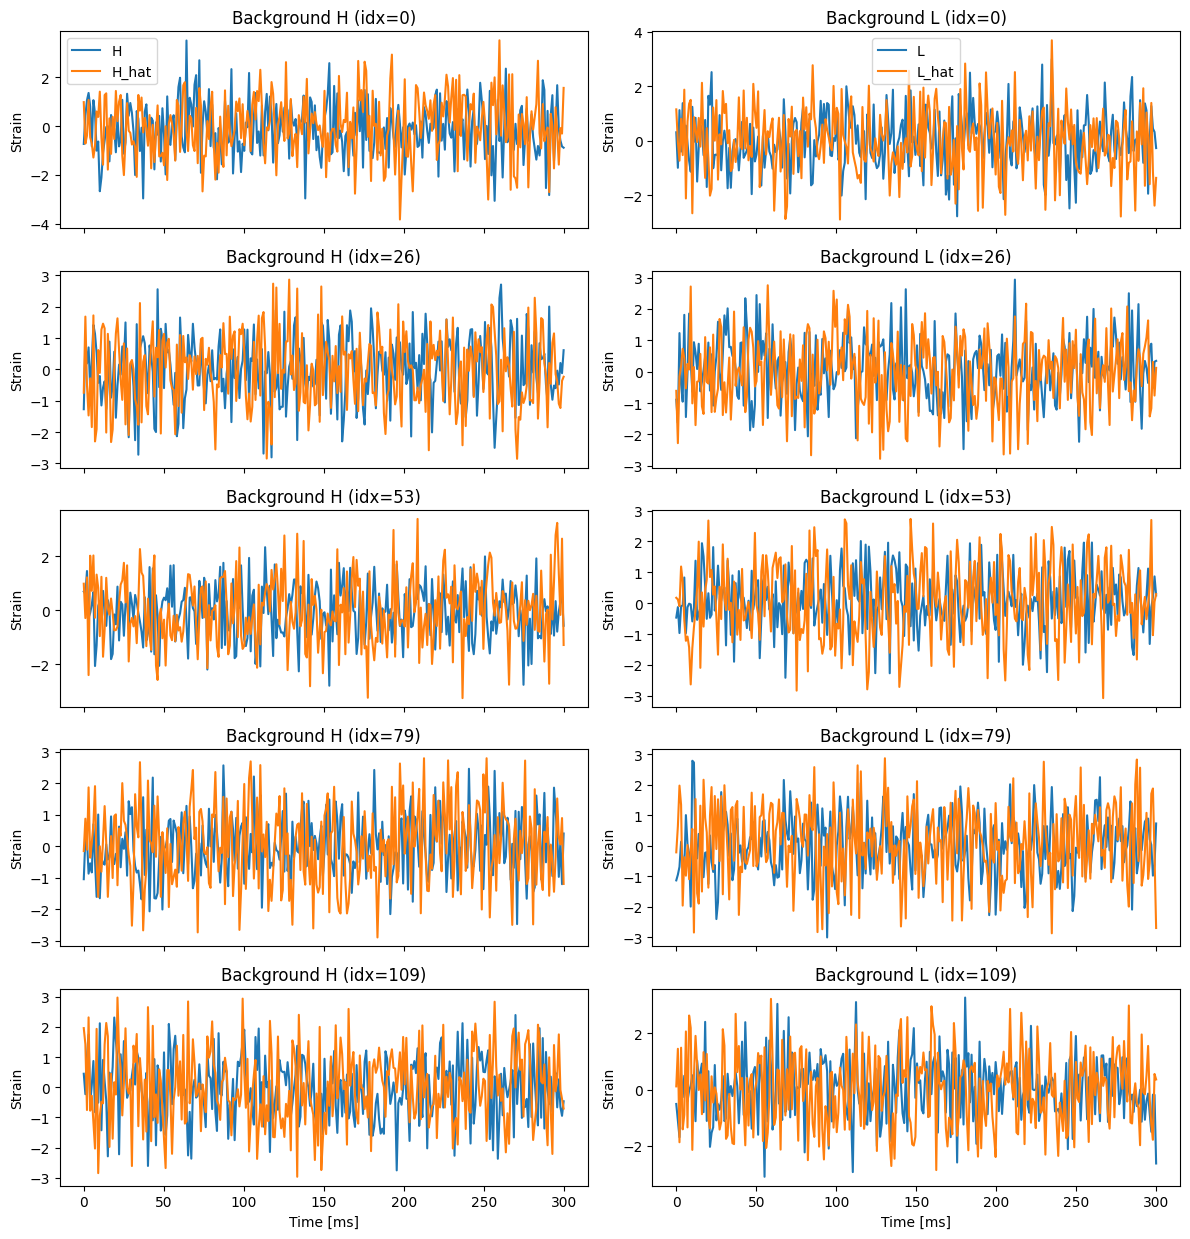

In [11]:
# Plot multiple background examples
num_examples = 5
bg_indices = np.where(labels == 0)[0]
if len(bg_indices) == 0:
    raise ValueError("No background samples available for plotting")

if len(bg_indices) >= num_examples:
    bg_indices = np.linspace(0, len(bg_indices) - 1, num_examples, dtype=int)
    bg_indices = bg_indices
    bg_indices = np.take(np.where(labels == 0)[0], bg_indices)
else:
    bg_indices = bg_indices

fig, axes = plt.subplots(len(bg_indices), 2, figsize=(12, 2.5 * len(bg_indices)), sharex=True)

if len(bg_indices) == 1:
    axes = np.array([axes])

for row, idx in enumerate(bg_indices):
    ax_h = axes[row, 0]
    ax_l = axes[row, 1]

    ax_h.plot(time, X_real_train[idx, 0, :], label="H")
    ax_h.plot(time, X_hat_train[idx, 0, :], label="H_hat")
    ax_h.set_ylabel("Strain")
    ax_h.set_title(f"Background H (idx={idx})")
    if row == 0:
        ax_h.legend()

    ax_l.plot(time, X_real_train[idx, 1, :], label="L")
    ax_l.plot(time, X_hat_train[idx, 1, :], label="L_hat")
    ax_l.set_ylabel("Strain")
    ax_l.set_title(f"Background L (idx={idx})")
    if row == 0:
        ax_l.legend()

for ax in axes[-1, :]:
    ax.set_xlabel("Time [ms]")

plt.tight_layout()
plt.show()


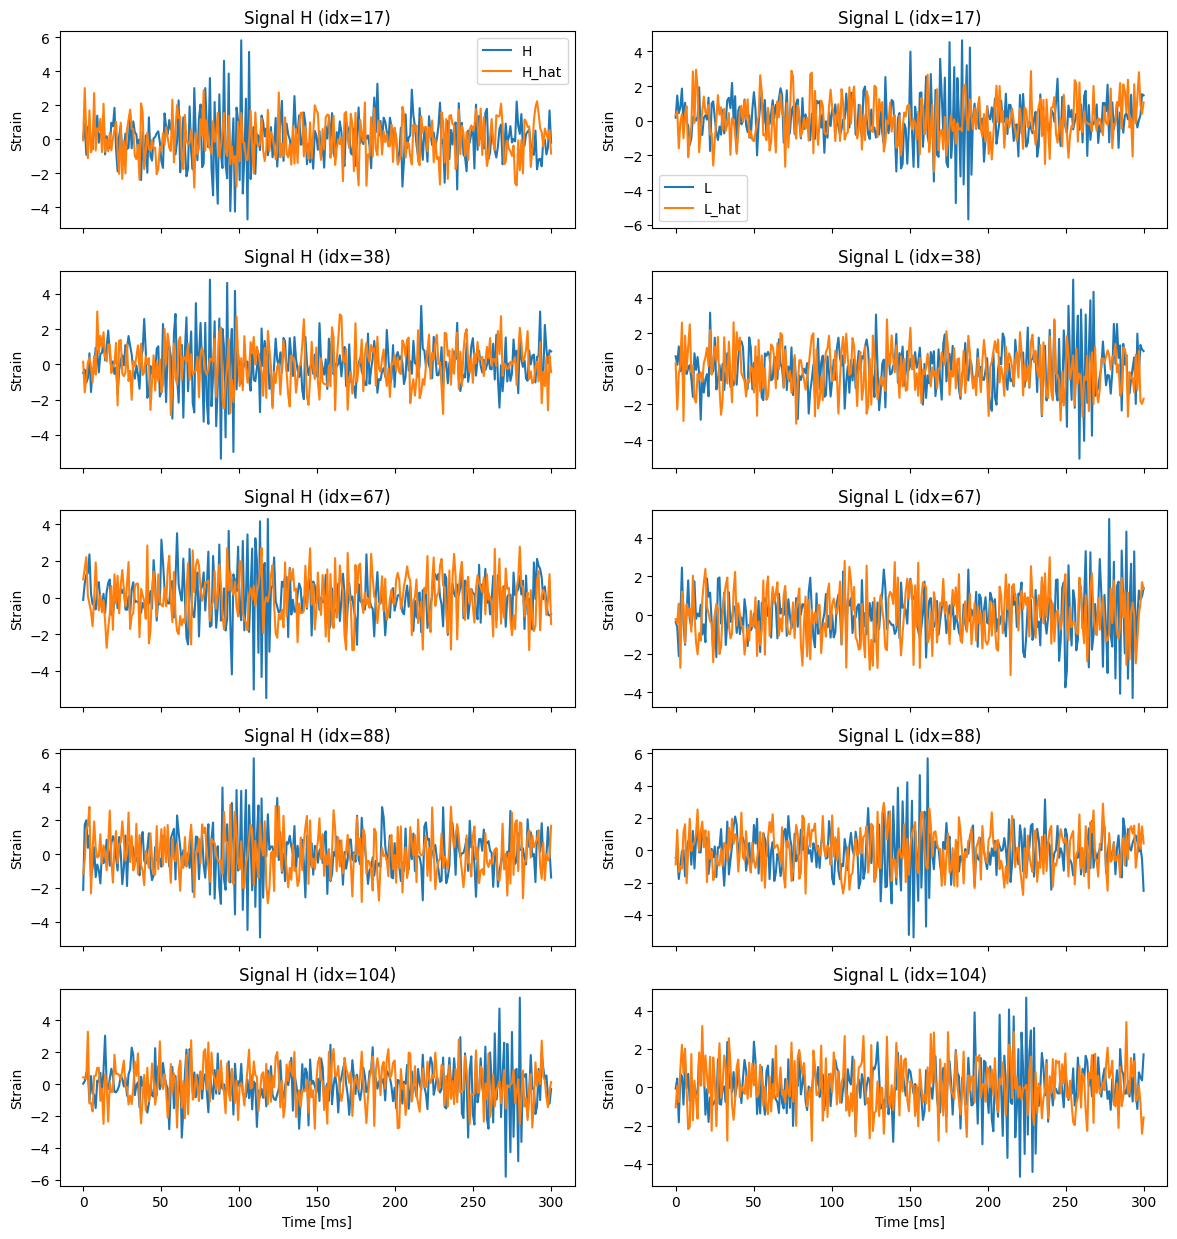

In [12]:
# Plot signal examples vs flow reconstruction
num_examples = 5
sig_indices = np.where(labels == 1)[0]
if len(sig_indices) == 0:
    raise ValueError("No signal samples available for plotting")

if len(sig_indices) >= num_examples:
    sig_indices = np.linspace(0, len(sig_indices) - 1, num_examples, dtype=int)
    sig_indices = np.take(np.where(labels == 1)[0], sig_indices)
else:
    sig_indices = sig_indices

fig, axes = plt.subplots(len(sig_indices), 2, figsize=(12, 2.5 * len(sig_indices)), sharex=True)

if len(sig_indices) == 1:
    axes = np.array([axes])

for row, idx in enumerate(sig_indices):
    ax_h = axes[row, 0]
    ax_l = axes[row, 1]

    ax_h.plot(time, X_real_train[idx, 0, :], label="H")
    ax_h.plot(time, X_hat_train[idx, 0, :], label="H_hat")
    ax_h.set_ylabel("Strain")
    ax_h.set_title(f"Signal H (idx={idx})")
    if row == 0:
        ax_h.legend()

    ax_l.plot(time, X_real_train[idx, 1, :], label="L")
    ax_l.plot(time, X_hat_train[idx, 1, :], label="L_hat")
    ax_l.set_ylabel("Strain")
    ax_l.set_title(f"Signal L (idx={idx})")
    if row == 0:
        ax_l.legend()

for ax in axes[-1, :]:
    ax.set_xlabel("Time [ms]")

plt.tight_layout()
plt.show()


## Train Classifier

In [13]:
if USE_EXTERNAL_CLASSIFIER:
    notebooks_dir = project_root / "notebooks"
    if str(notebooks_dir) not in sys.path:
        sys.path.insert(0, str(notebooks_dir))
    import model as gw_model

    class ExternalGWClassifier(nn.Module):
        def __init__(self, input_length=600):
            super().__init__()
            self.base = gw_model.create_model(input_length=input_length)
            self.use_time = False

        def forward(self, x, t=None):
            # x: (B,2,300) -> (B,1,600)
            x = torch.cat([x[:, 0, :], x[:, 1, :]], dim=1).unsqueeze(1)
            prob = self.base(x)
            prob = prob.clamp(1e-6, 1 - 1e-6)
            return torch.logit(prob)
else:
    class CNNClassifierWithTime(nn.Module):
        def __init__(self, use_time=False):
            super().__init__()
            self.use_time = use_time

            self.feature_net = nn.Sequential(
                nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                nn.ReLU(inplace=True),
                nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
                nn.ReLU(inplace=True),
                nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool1d(1),
            )
            in_dim = 64 + (1 if use_time else 0)
            self.head = nn.Linear(in_dim, 1)

        def forward(self, x, t=None):
            h = self.feature_net(x).squeeze(-1)
            if self.use_time:
                if t is None:
                    raise ValueError("use_time=True but t was None")
                t = t.view(-1, 1)
                h = torch.cat([h, t], dim=1)
            return self.head(h).squeeze(-1)

class RealVsEstimatedDatasetWithTime(Dataset):
    def __init__(self, X_real, X_est, t_cond):
        N = X_real.size(0)
        self.X = torch.cat([X_real, X_est], dim=0)  # (2N,2,300)
        self.y = torch.cat([torch.ones(N), torch.zeros(N)], dim=0)

        t = torch.as_tensor(t_cond, dtype=torch.float32)
        self.t = torch.cat([t, t], dim=0)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.t[idx]


Epoch 1/50 | BCE: 0.696039
Epoch 2/50 | BCE: 0.692804
Epoch 3/50 | BCE: 0.690397
Epoch 4/50 | BCE: 0.688653
Epoch 5/50 | BCE: 0.687381
Epoch 6/50 | BCE: 0.686514
Epoch 7/50 | BCE: 0.685927
Epoch 8/50 | BCE: 0.685403
Epoch 9/50 | BCE: 0.684757
Epoch 10/50 | BCE: 0.683888
Epoch 11/50 | BCE: 0.682820
Epoch 12/50 | BCE: 0.681633
Epoch 13/50 | BCE: 0.680432
Epoch 14/50 | BCE: 0.679265
Epoch 15/50 | BCE: 0.678124
Epoch 16/50 | BCE: 0.676952
Epoch 17/50 | BCE: 0.675693
Epoch 18/50 | BCE: 0.674302
Epoch 19/50 | BCE: 0.672761
Epoch 20/50 | BCE: 0.671086
Epoch 21/50 | BCE: 0.669312
Epoch 22/50 | BCE: 0.667438
Epoch 23/50 | BCE: 0.665405
Epoch 24/50 | BCE: 0.663144
Epoch 25/50 | BCE: 0.660611
Epoch 26/50 | BCE: 0.657804
Epoch 27/50 | BCE: 0.654745
Epoch 28/50 | BCE: 0.651429
Epoch 29/50 | BCE: 0.647785
Epoch 30/50 | BCE: 0.643714
Epoch 31/50 | BCE: 0.639191
Epoch 32/50 | BCE: 0.634243
Epoch 33/50 | BCE: 0.628866
Epoch 34/50 | BCE: 0.622983
Epoch 35/50 | BCE: 0.616569
Epoch 36/50 | BCE: 0.609658
E

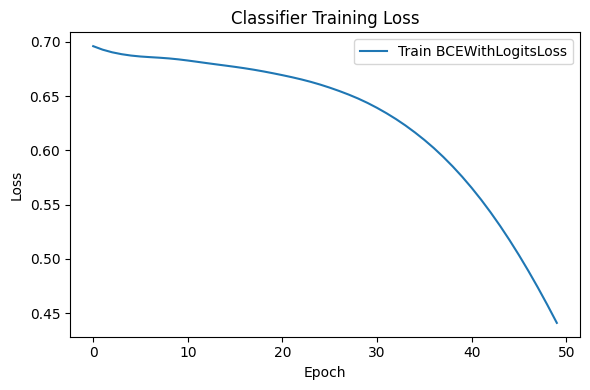

In [14]:
def train_classifier(model, loader, epochs=50, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    train_losses = []

    for ep in range(epochs):
        model.train()
        total = 0.0
        count = 0

        for xb, yb, tb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            tb = tb.to(device)

            opt.zero_grad()
            logits = model(xb, tb if model.use_time else None)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            total += loss.item() * xb.size(0)
            count += xb.size(0)
        train_losses.append(total / count)

        print(f"Epoch {ep+1}/{epochs} | BCE: {total/count:.6f}")

    return model, train_losses

if USE_EXTERNAL_CLASSIFIER:
    use_time_for_classifier = False
    clf = ExternalGWClassifier()
else:
    clf = CNNClassifierWithTime(use_time=use_time_for_classifier)

clf_ds = RealVsEstimatedDatasetWithTime(X_real_train, X_hat_train, train_t)
clf_loader = DataLoader(clf_ds, batch_size=256, shuffle=True)

clf, train_losses = train_classifier(clf, clf_loader, epochs=NUM_CLASSIFIER_EPOCHS, lr=1e-3)

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train BCEWithLogitsLoss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classifier Training Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
def anomaly_scores_classifier(model, h_windows, l_windows, t_cond, batch_size=512):
    X = torch.stack([torch.as_tensor(h_windows, dtype=torch.float32),
                     torch.as_tensor(l_windows, dtype=torch.float32)], dim=1)  # (N,2,300)

    t = torch.as_tensor(t_cond, dtype=torch.float32)

    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(0, X.size(0), batch_size):
            xb = X[i:i+batch_size].to(device)
            tb = t[i:i+batch_size].to(device)
            logits = model(xb, tb if model.use_time else None)
            scores.append(torch.sigmoid(logits).cpu())
    return torch.cat(scores, dim=0)

scores_eval = anomaly_scores_classifier(clf, train_hn, train_ln, train_t)

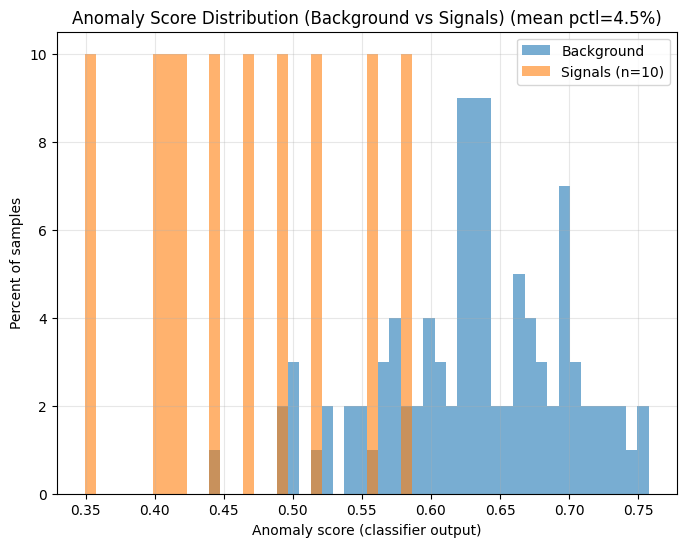

Signal percentile mean: 4.50%
Signal percentile min/max: 0.00% / 21.00%


In [16]:
scores_np = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

bg_scores = scores_np[labels == 0]
sig_scores = scores_np[labels == 1]

bins = 50
# Optional x-axis window: set to (xmin, xmax) or leave as None
xlim_window = None

if xlim_window is not None:
    xmin, xmax = xlim_window
    bin_edges = np.linspace(xmin, xmax, bins + 1)
else:
    all_scores = np.concatenate([bg_scores, sig_scores]) if len(sig_scores) else bg_scores
    bin_edges = np.histogram_bin_edges(all_scores, bins=bins)

bg_weights = np.ones_like(bg_scores) * (100.0 / len(bg_scores)) if len(bg_scores) else None
sig_weights = np.ones_like(sig_scores) * (100.0 / len(sig_scores)) if len(sig_scores) else None

sig_percentiles = [(bg_scores < s).mean() * 100 for s in sig_scores]
mean_pct = float(np.mean(sig_percentiles)) if len(sig_scores) else float("nan")

plt.figure(figsize=(8, 6))
plt.hist(bg_scores, bins=bin_edges, weights=bg_weights, alpha=0.6, label="Background")
if len(sig_scores):
    plt.hist(sig_scores, bins=bin_edges, weights=sig_weights, alpha=0.6, label=f"Signals (n={len(sig_scores)})")
if xlim_window is not None:
    plt.xlim(*xlim_window)
plt.xlabel("Anomaly score (classifier output)")
plt.ylabel("Percent of samples")
plt.title(f"Anomaly Score Distribution (Background vs Signals) (mean pctl={mean_pct:.1f}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

if len(sig_scores):
    print(f"Signal percentile mean: {mean_pct:.2f}%")
    print(f"Signal percentile min/max: {min(sig_percentiles):.2f}% / {max(sig_percentiles):.2f}%")


In [17]:
scores_np = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

score_df = pd.DataFrame({
    "score": scores_np,
    "label": labels,
})
score_df = score_df.sort_values("score", ascending=False).reset_index(drop=True)

output_path = "anomaly_scores.csv"
score_df.to_csv(output_path, index=False)
print(f"Saved anomaly scores to {output_path}")


Saved anomaly scores to anomaly_scores.csv


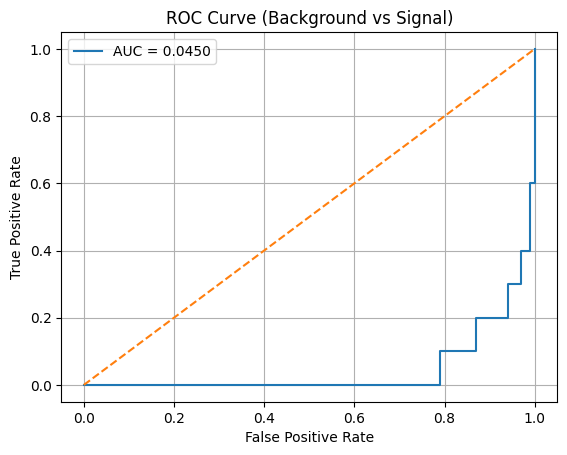

In [18]:
# Convert scores to a NumPy array
scores = scores_eval.detach().cpu().numpy() if hasattr(scores_eval, "detach") else np.asarray(scores_eval)

# ROC points + AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc = roc_auc_score(labels, scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Background vs Signal)")
plt.legend()
plt.grid(True)
plt.show()